In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append("./Code")
from InstructionDecoder import InstructionDecoder
import DataCleanup

In [2]:
def _pass_(oc):
    i = InstructionDecoder(oc)
    _alive_ = i.getAliveStatus()
    _oc_stat_ = i.getOcStatus()
    _temp_stat_ = i.getTemperatureStatus()
    _compute_stat_ = i.getComputeStatus()
    
    if _alive_*_oc_stat_*_temp_stat_*_compute_stat_ == 0:
        return False
    else:
        return True

In [3]:
dataFolder = './data750Ti_2'
files = DataCleanup.readDataDirectory(dataFolder)
profiles = [np.load(dataFolder + "/" + f) for f in files]
oc_codes = [int(f.strip('.npy')) for f in files]

In [24]:
oc_data = []
with open(dataFolder+"/oc.profiles", "rb") as f:
    oc_data = f.read().decode().split(' ')[:-1]
oc_data = [int(d) for d in oc_data]
print(oc_data, len(oc_data))

[1649267441667, 1651456868355, 1651498811395, 1651540754435, 1651582697475, 1651624640515, 552154955778, 552133984258, 552123498498, 1651629883395, 1651635126275, 1651640369155, 552133984258, 552130838530, 552129789954, 552128741378, 552127692802, 552126644226, 1651637223427, 1651637223427, 1651637223427, 552125595650, 1651636174851, 1651636174851, 1651636174851, 1651636174851, 1651636174851, 552124547074, 1651635126275, 1651635126275, 552123498498, 1651634077699, 1651634077699, 552122449922, 1651633029123, 1651633029123, 1651633029123, 1651633029123, 1651633029123, 552121401346, 1651631980547, 1651631980547, 552120352770, 1651630931971, 1651630931971, 1651630931971, 1651630931971, 1651630931971, 1651630931971, 552119304194, 1651629883395, 552118255618, 1651628834819, 1651628834819, 1651628834819, 552117207042, 1651627786243, 1651627786243, 1651627786243, 1651627786243, 1651627786243, 552116158466, 1651626737667, 1651626737667, 1651626737667, 1651626737667, 1651626737667, 1651626737667

The above shows all the overclock profiles that were applied to the system

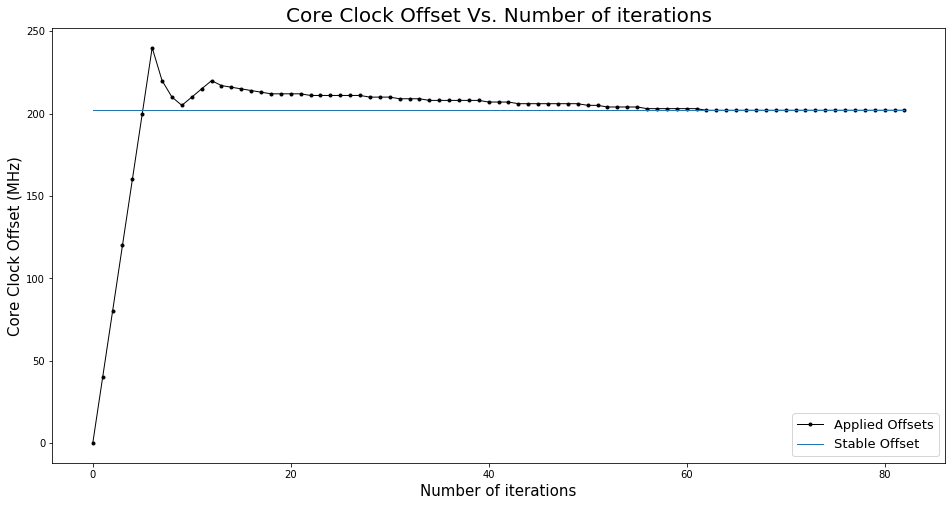

In [17]:
actual = InstructionDecoder(oc_data[-1]).getClockOffset()
values = [
    InstructionDecoder(oc).getClockOffset() 
    for oc in oc_data 
    if InstructionDecoder(oc).getMemoryOffset() == 0
]

plt.figure(figsize=(16, 8))
plt.title("Core Clock Offset Vs. Number of iterations", fontsize=20)
plt.ylabel("Core Clock Offset (MHz)", fontsize=15)
plt.xlabel("Number of iterations", fontsize=15)
plt.plot(values, '-ok', label='Applied Offsets', linewidth=1, markersize=3)
plt.plot([actual]*len(values), '-', label='Stable Offset', linewidth=1)
plt.legend(loc='lower right', fontsize=13)
plt.show()

The above plot displays the overclock profiles for core clock overclock applied to system by our algorithm. As can be seen in the above plot, the desired offset that will give a stable overclock is at around 200Mhz. A core stable overclock is a clock offset from the base clock that will not crash the system when stress tested and will not reduce the computational accuracy.

In the above plot, our algorithm starts will an offset of 0MHz from the base clock. Applying this offset does not cause the system to crash or reuce its computational accuracy as expected. This OC profile is then sent to the server hosting the OC algorithm. The algorithm on the server sees that this OC profile was stable - here stability refers to the application of a core stable overclock. The algorithm on the server sets this OC profile as the last known good stable profile. It then applies an offset of 40MHz to this last known good stable profile and sends it to the client to be tested. This 40MHz is the clock increment value of the algorithm.

The client now receives an OC profile from the server with a 40MHz overclock offset from the base. The client applies this new OC profile and stress tests the system for stability and accuracy. The stress test passes and this OC profile along with the profile status is sent to the server.

The server receives this OC profile from the client and sends it to the OC algorithm. The OC algorithm after checking the status of the received profile to see if it was a pass or a fail. If the status is a fail the algorithm halves the clock increment value it applied to the last profile and generates a new profile from the last known good profile by increasing the clock offset by the halved clock increment. If the status is a pass, the last known good profile is set to this received value and a new profile is generated by increasing the clock offset in the last known good profile by the clock increment value.

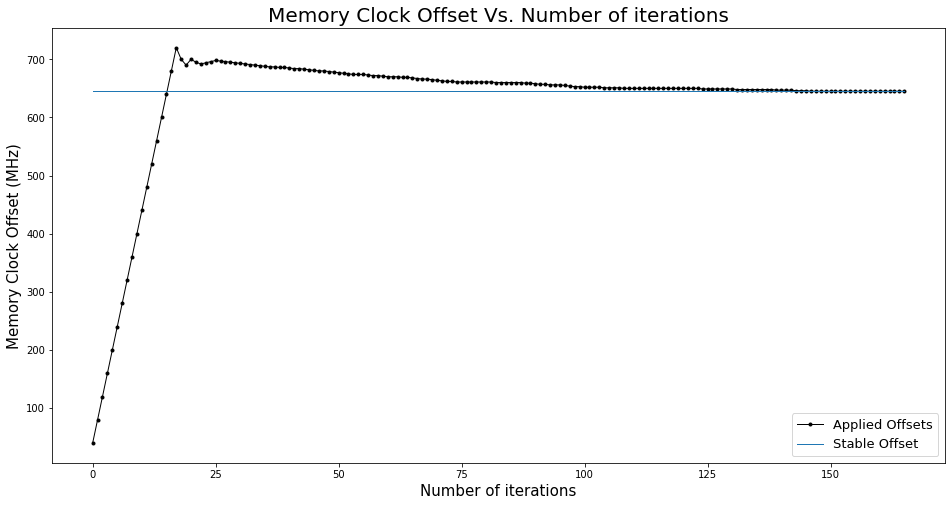

In [19]:
actual = InstructionDecoder(oc_data[-1]).getMemoryOffset()
values = [
    InstructionDecoder(oc).getMemoryOffset() 
    for oc in oc_data 
    if InstructionDecoder(oc).getMemoryOffset() != 0
]

plt.figure(figsize=(16, 8))
plt.title("Memory Clock Offset Vs. Number of iterations", fontsize=20)
plt.ylabel("Memory Clock Offset (MHz)", fontsize=15)
plt.xlabel("Number of iterations", fontsize=15)
plt.plot(values, '-ok', label='Applied Offsets', linewidth=1, markersize=3)
plt.plot([actual]*len(values), '-', label='Stable Offset', linewidth=1)
plt.legend(loc='lower right', fontsize=13)
plt.show()

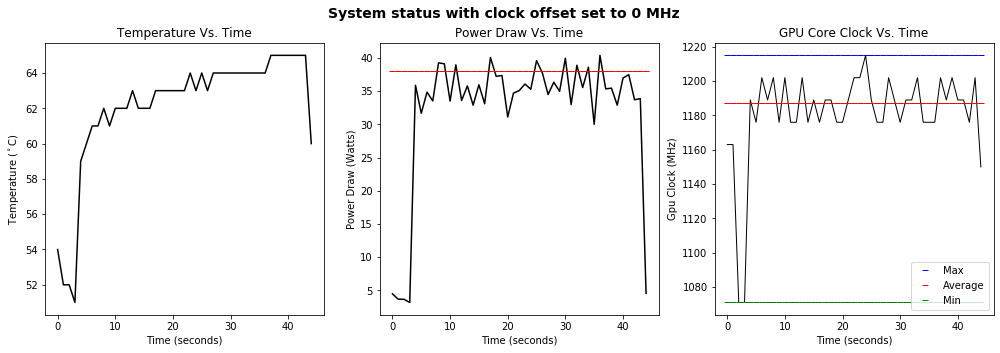

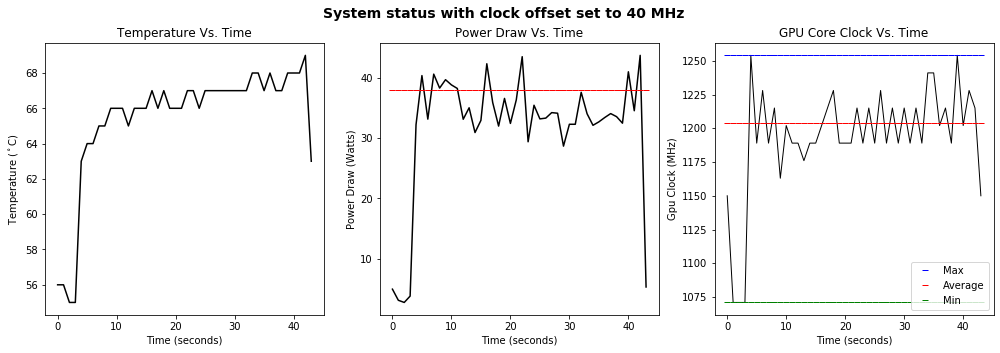

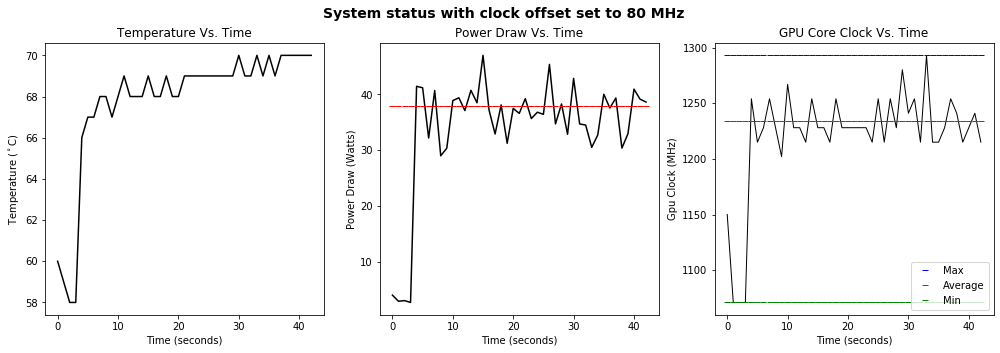

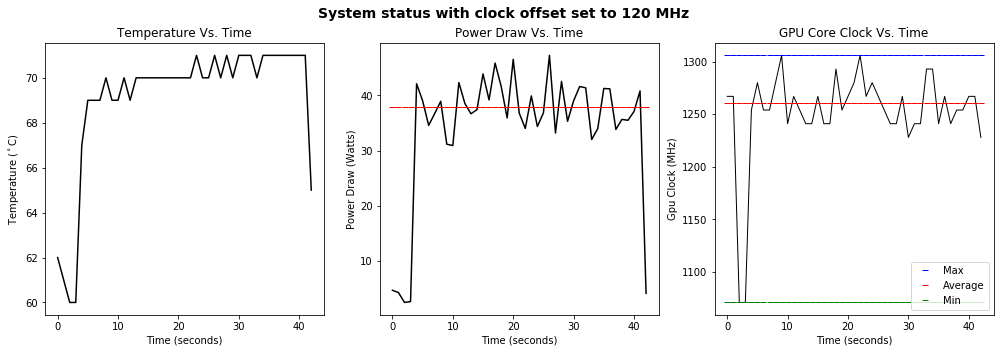

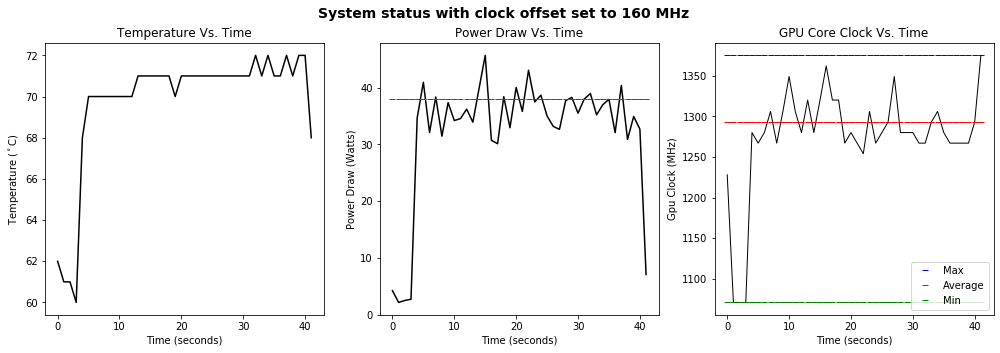

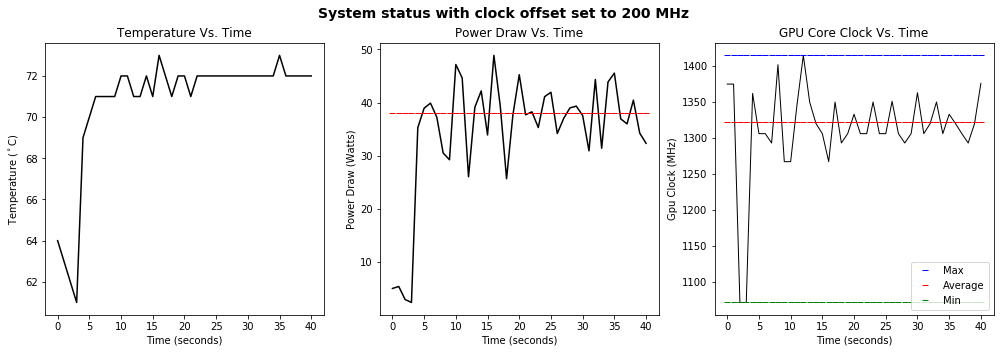

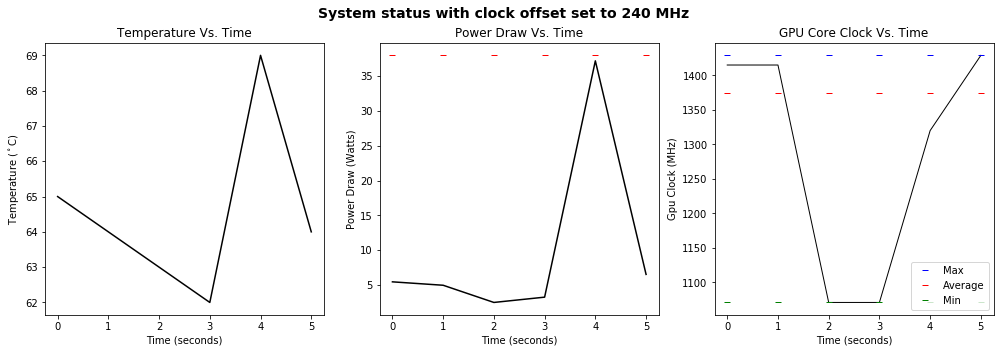

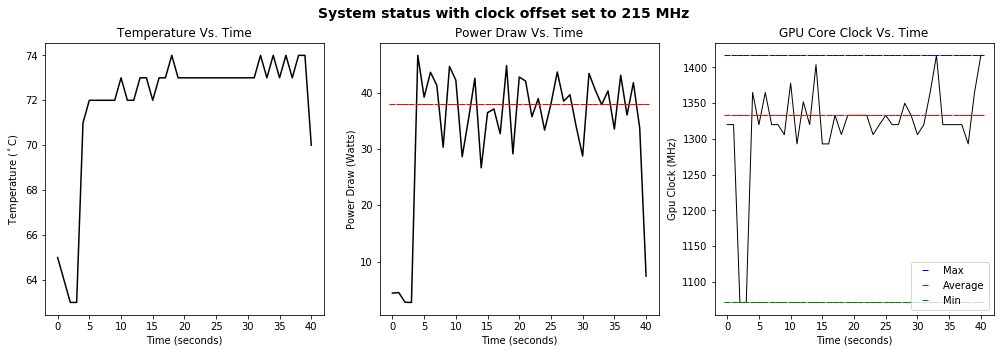

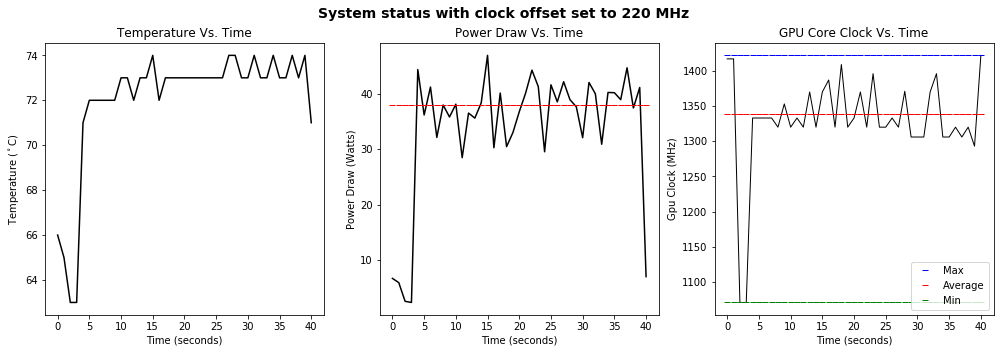

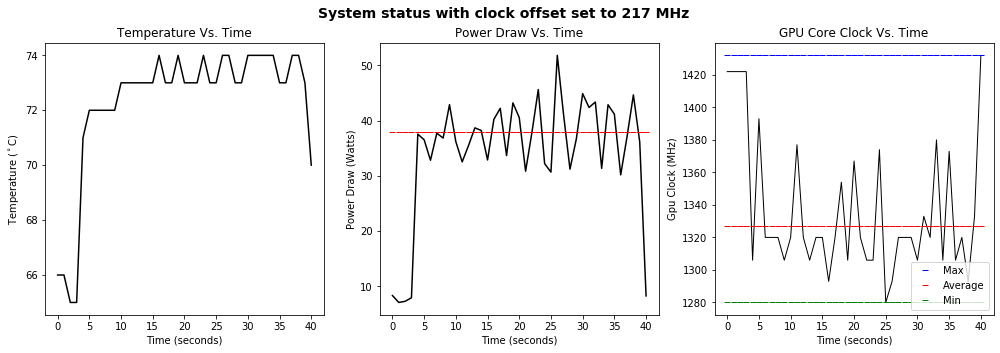

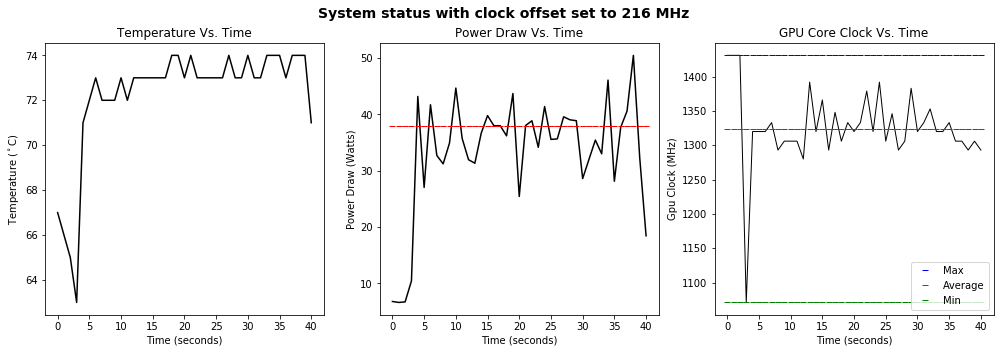

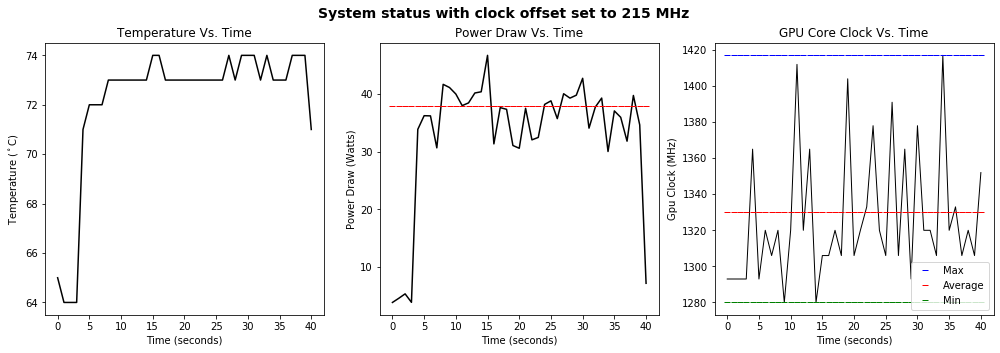

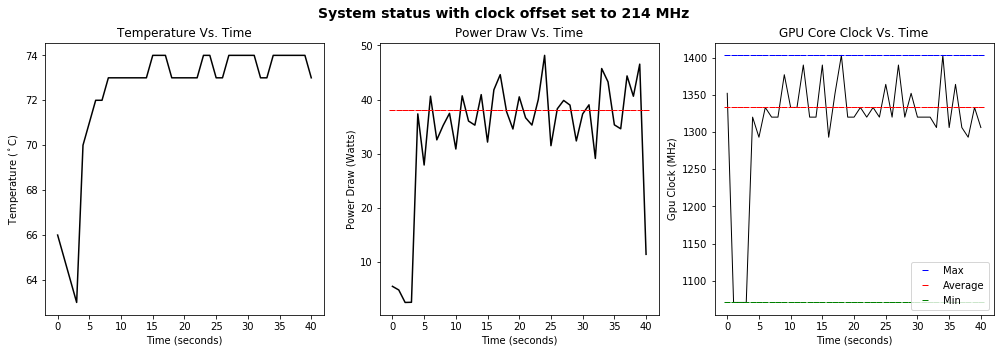

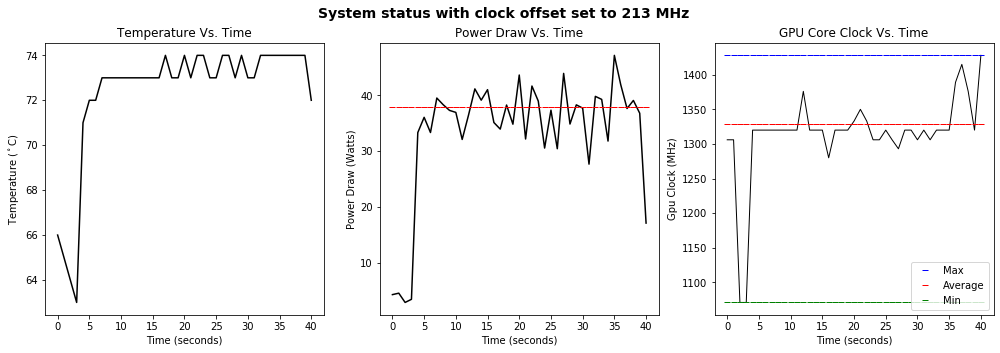

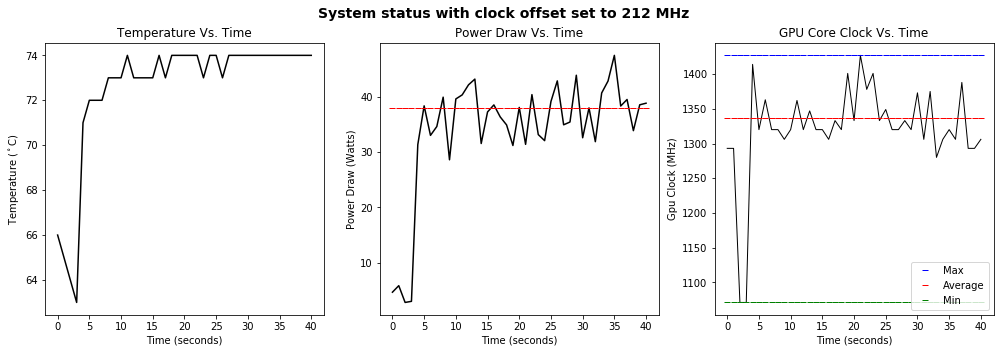

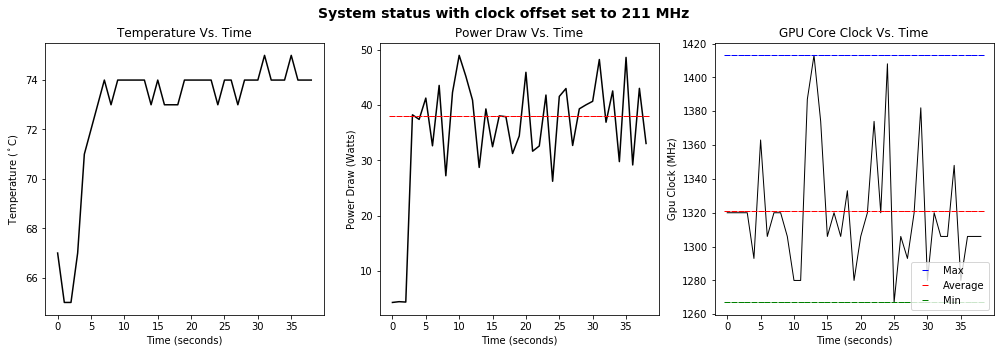

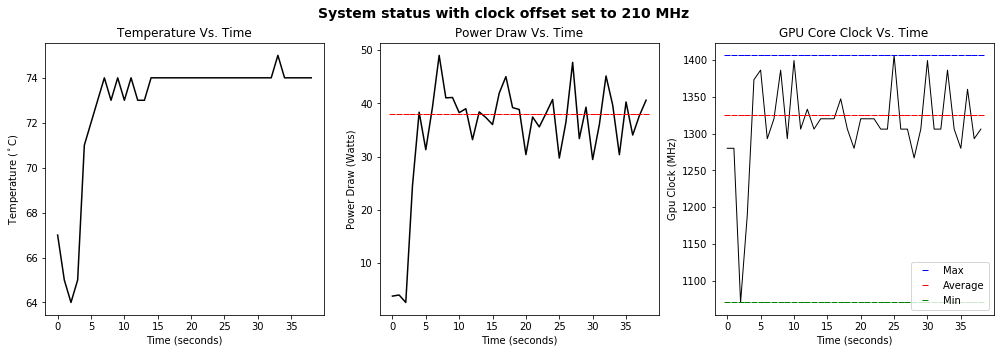

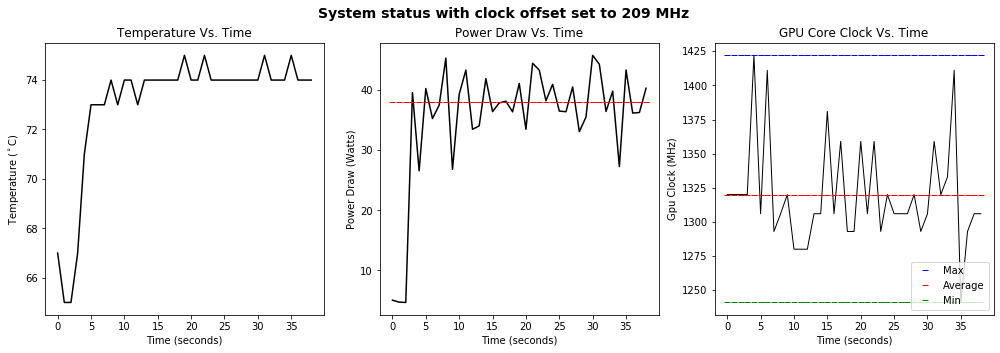

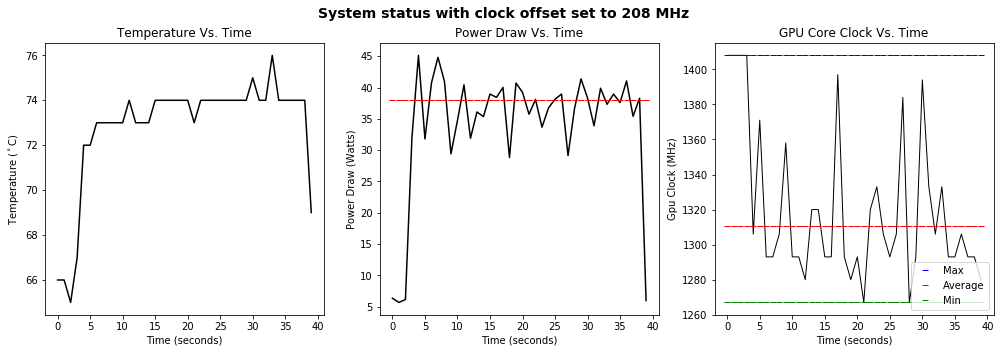

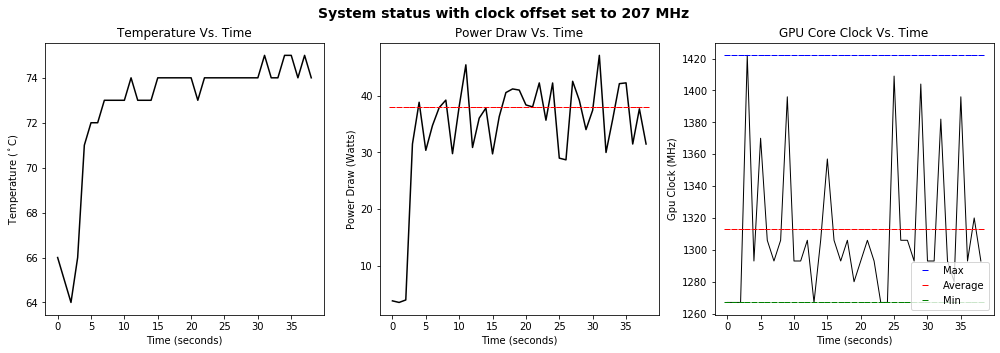

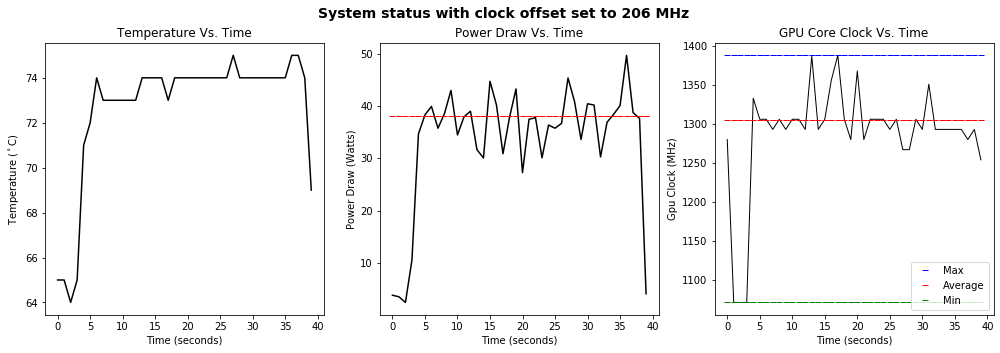

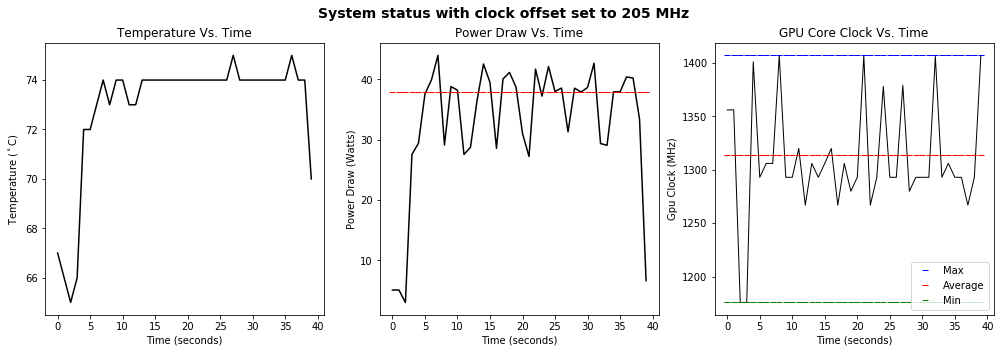

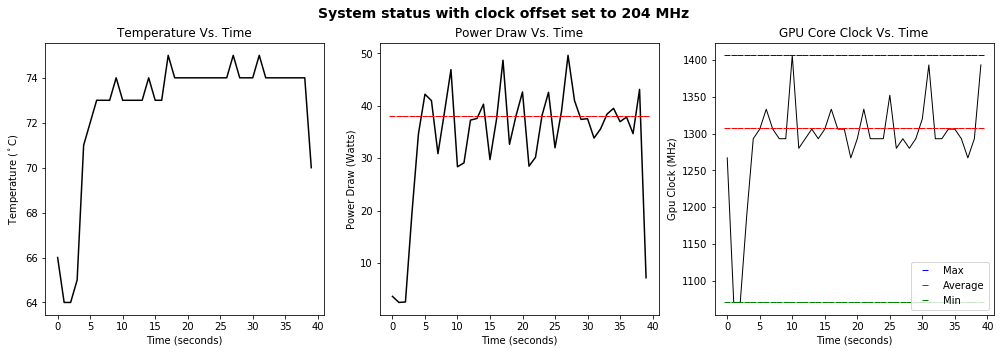

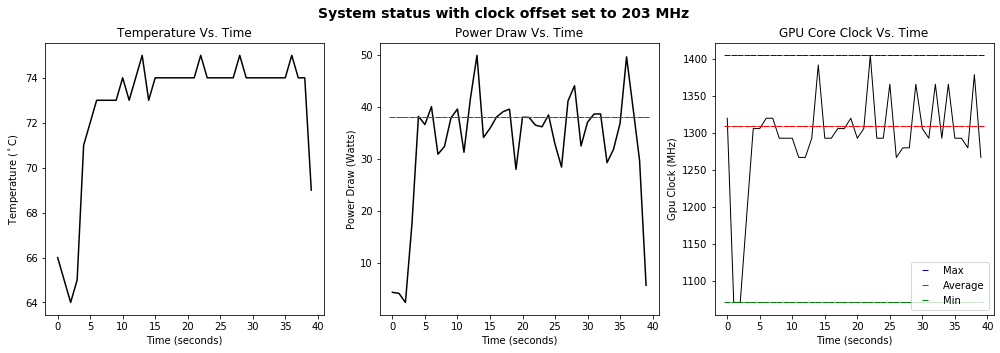

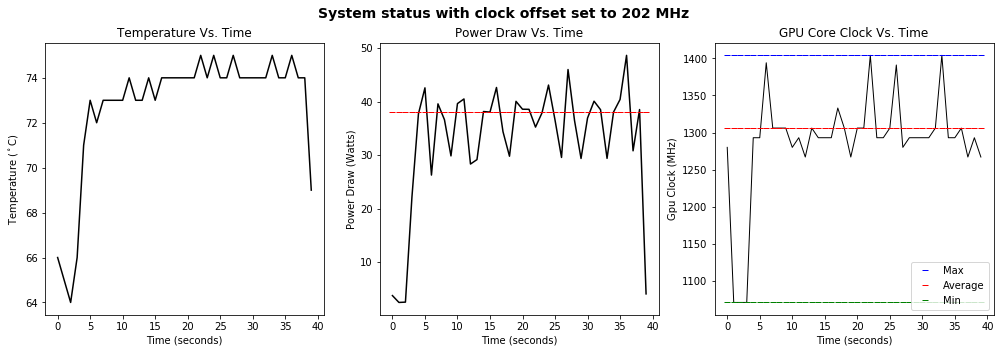

In [30]:
previous_core_offset = -1
nrows = 1
ncols = 3
sample_rate = 1/1
for i in range(len(profiles)):
    instruction = InstructionDecoder(oc_codes[i])
    clock_offset = 1346 + instruction.getClockOffset()
    
    title_ = ''
    
    # filter failed OC profiles
    if  instruction.getOcStatus()==0 or \
        instruction.getAliveStatus()==0 or \
        instruction.getTemperatureStatus()==0 or \
        instruction.getComputeStatus==0:
        title_ = "System status with clock offset set to %s MHz"%(str(instruction.getClockOffset()))
    else:
        title_ = "System status with clock offset set to %s MHz"%(str(instruction.getClockOffset()))
        
    if instruction.getClockOffset() == previous_core_offset:
        continue
    else:
        previous_core_offset = instruction.getClockOffset()
    
    temperature = profiles[i][:,0]
    power_draw = profiles[i][:,1]
    gpu_core_clock = profiles[i][:,2]
    sm_clock = profiles[i][:,3]
    memory_clock = profiles[i][:,4]
    time_axis = [sample_rate*i for i in range(len(gpu_core_clock))]
    

    plt.figure(figsize=(17, 5)).suptitle(title_, fontsize=14, fontweight='bold', va='top')
    
    plt.subplot(nrows, ncols, 1)
    plt.title("Temperature Vs. Time")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Temperature ($^\circ$C)')
    plt.plot(time_axis, temperature, '-k')
    
    plt.subplot(nrows, ncols, 2)
    plt.title("Power Draw Vs. Time")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Power Draw (Watts)')
    plt.plot(time_axis, power_draw, '-k')
    plt.plot(time_axis, [38]*len(power_draw), '_r', label='Max Rating')
    
    plt.subplot(nrows, ncols, 3)
    plt.title("GPU Core Clock Vs. Time")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Gpu Clock (MHz)')
    plt.plot(time_axis, gpu_core_clock, 'k', linewidth=1.0)
    plt.plot([np.max(gpu_core_clock)]*int(np.ceil(time_axis[-1])+1), '_b', label='Max')
    plt.plot([np.mean(gpu_core_clock[4:])]*int(np.ceil(time_axis[-1])+1), '_r', label='Average')
    plt.plot([np.min(gpu_core_clock)]*int(np.ceil(time_axis[-1])+1), '_g', label='Min')
    plt.legend(loc='lower right')
    
    plt.show()

[0, 40, 80, 120, 160, 200, 215, 212, 211, 210, 209, 208, 207, 206, 205, 204, 203, 202]
[45, 44, 43, 43, 42, 41, 41, 41, 39, 39, 39, 40, 39, 40, 40, 40, 40, 40]


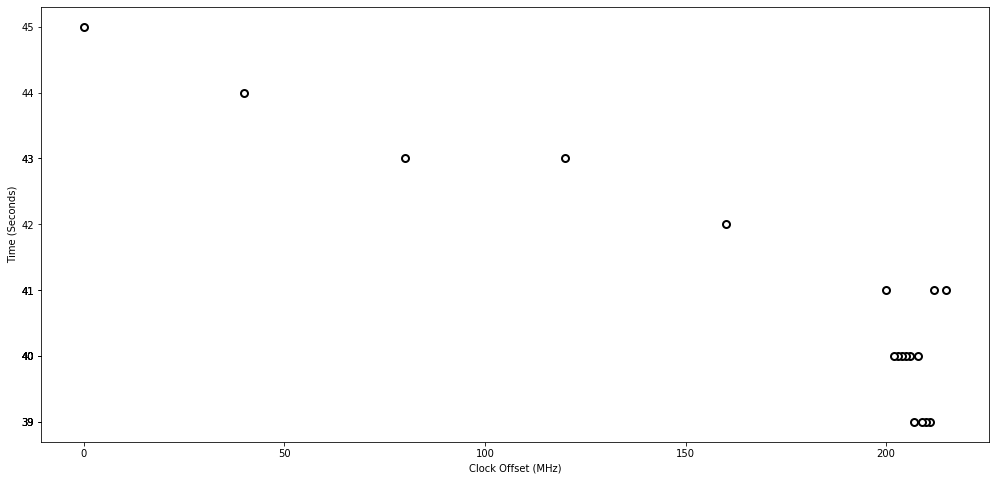

[40, 80, 120, 160, 200, 240, 280, 320, 360, 400, 440, 480, 520, 560, 600, 640, 690, 692, 694, 696, 687, 686, 684, 680, 674, 672, 670, 669, 666, 662, 661, 660, 659, 657, 656, 653, 652, 651, 650, 649, 648, 647, 646, 645]
[39, 39, 39, 39, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 38, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39, 39]


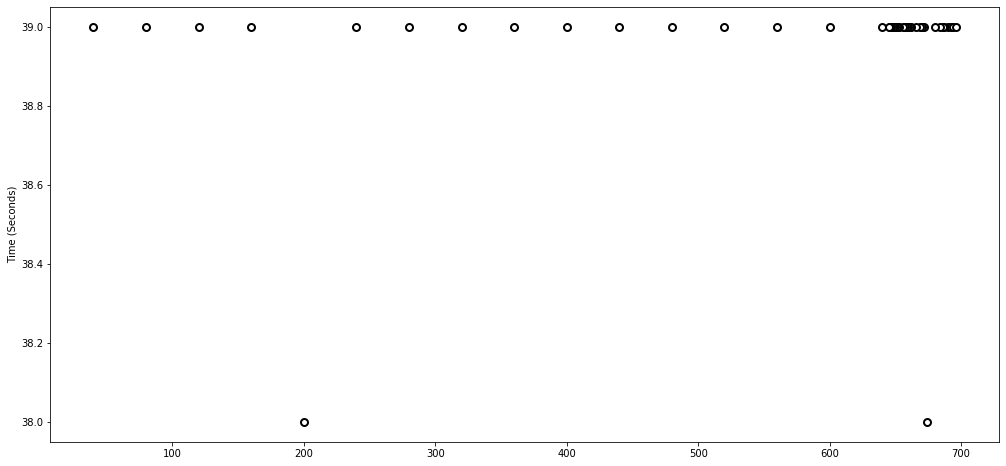

In [21]:
# get time taken for stress process during overclocking as 
# core clock offset is increased
core_clock_offset, _time_ = [], []
for i in range(len(profiles)):
    instruction = InstructionDecoder(oc_codes[i])
    
    if not _pass_(oc_codes[i]): 
        continue
        
    if instruction.getMemoryOffset() != 0:
        continue
        
    core_clock_offset += [instruction.getClockOffset()]
    _time_ += [len(profiles[i])]
    
print(core_clock_offset)
print(_time_)
plt.figure(figsize=(17,8))
plt.ylabel("Time (Seconds)")
plt.xlabel("Clock Offset (MHz)")
# plt.xticks(core_clock_offset)
plt.yticks(_time_)
plt.plot(core_clock_offset, _time_, 'ok', markersize=7, markeredgewidth=2, markerfacecolor='white')
plt.show()


# get time taken for stress process during overclocking as 
# memory clock offset is increased
memory_clock_offset, _time_ = [], []
for i in range(len(profiles)):
    instruction = InstructionDecoder(oc_codes[i])
    
    if not _pass_(oc_codes[i]): 
        continue
        
    if instruction.getMemoryOffset() == 0:
        continue
        
    memory_clock_offset += [instruction.getMemoryOffset()]
    _time_ += [len(profiles[i])]

print(memory_clock_offset)
print(_time_)
plt.figure(figsize=(17,8))
plt.ylabel("Time (Seconds)")
plt.plot(memory_clock_offset, _time_, 'ok', markersize=7, markeredgewidth=2, markerfacecolor='white')
plt.show()

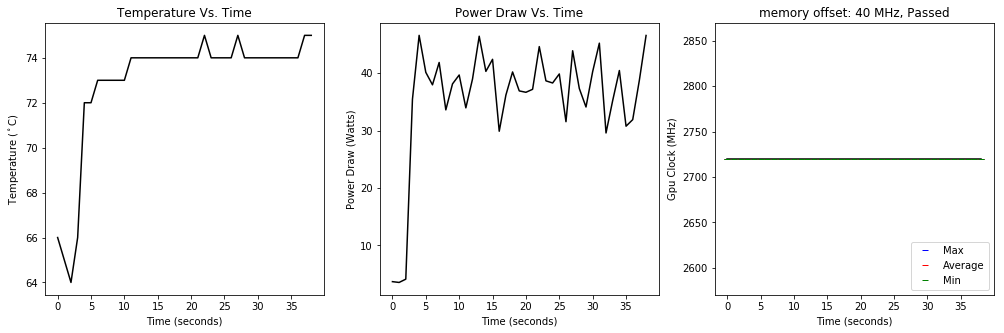

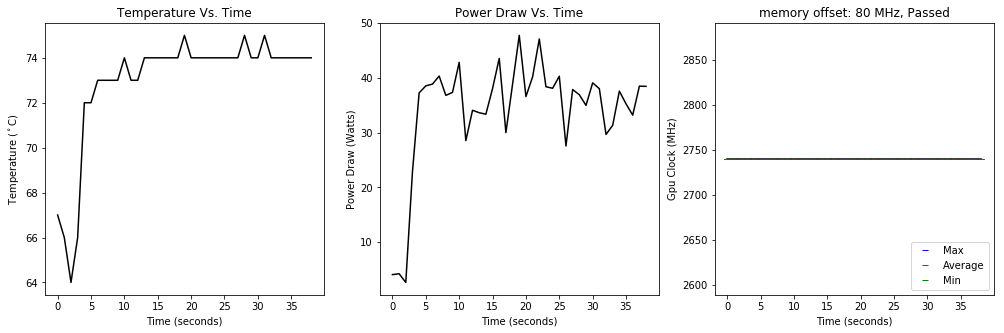

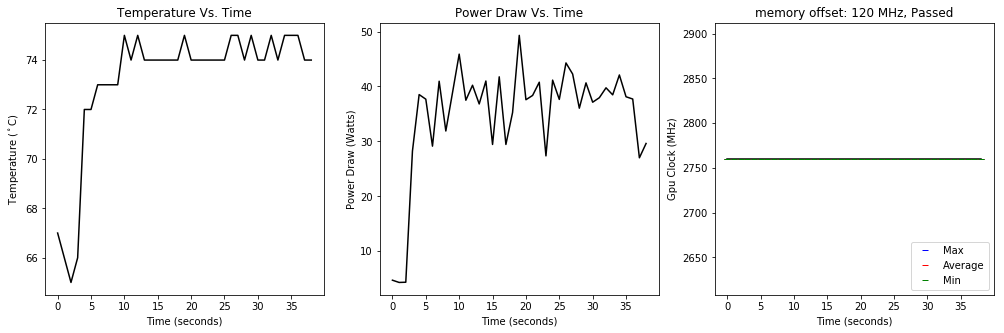

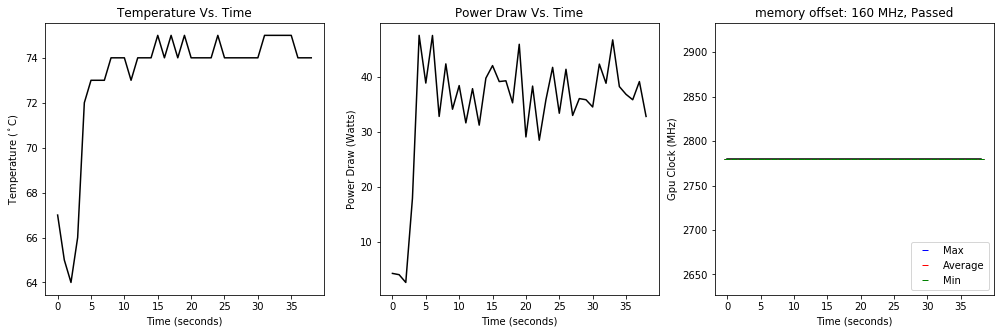

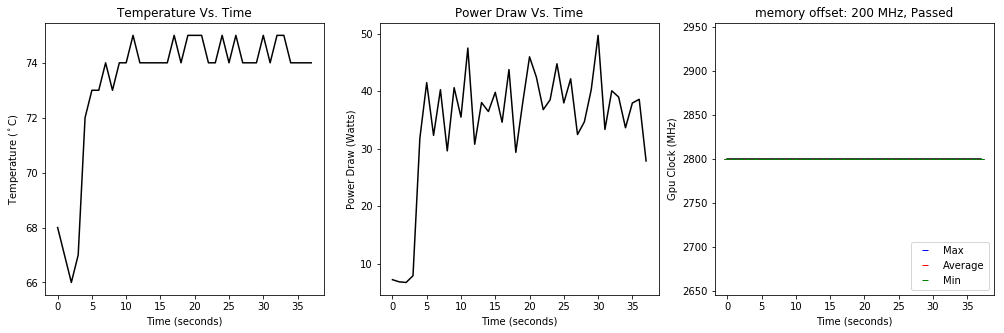

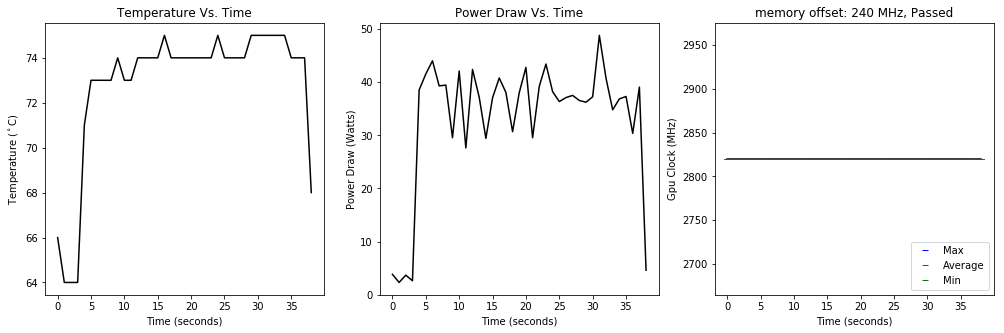

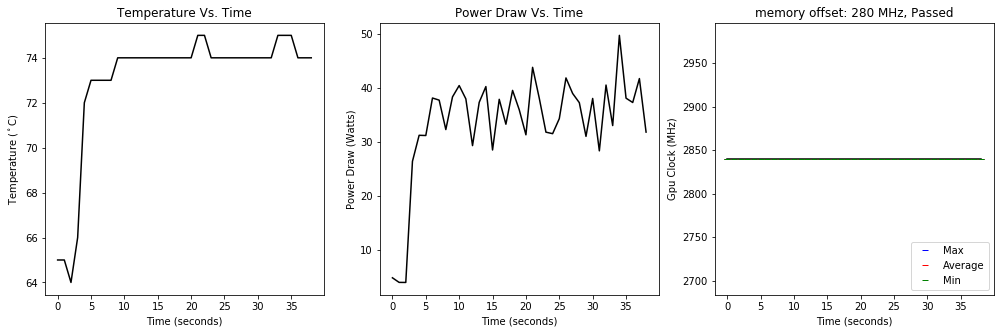

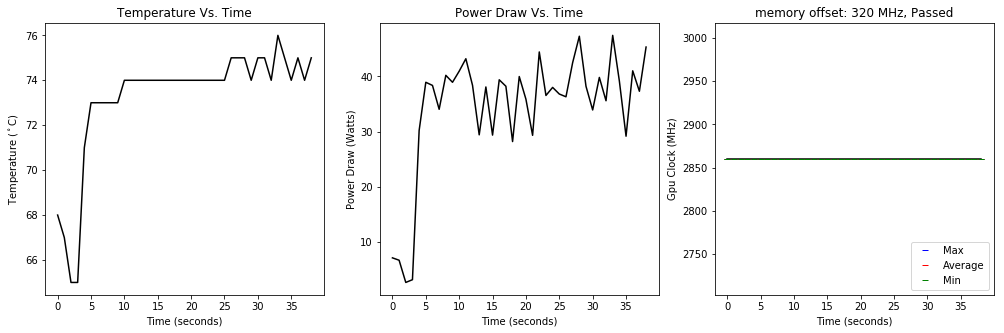

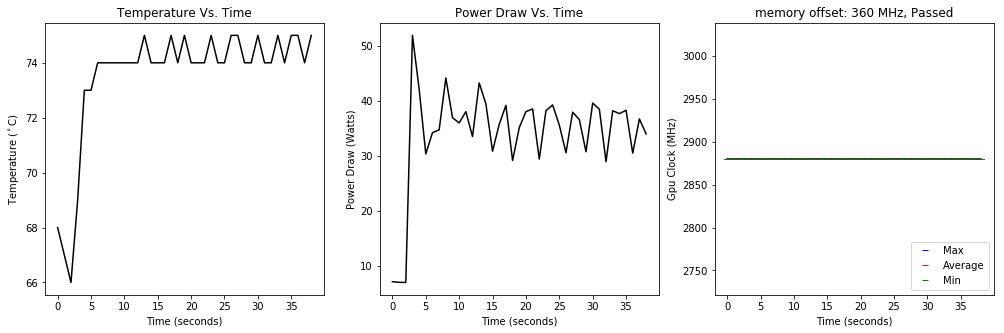

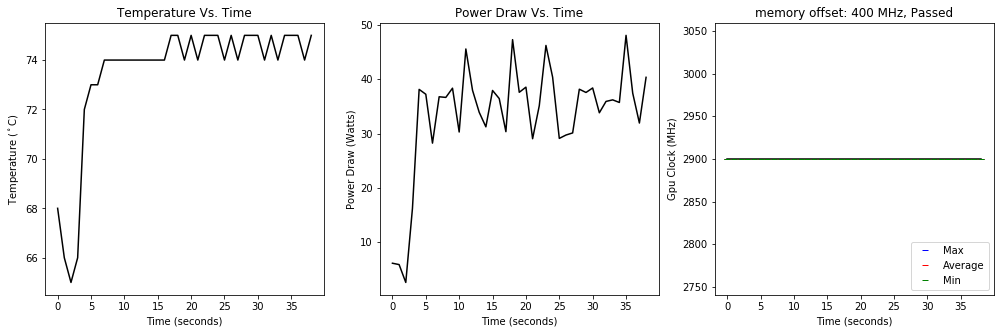

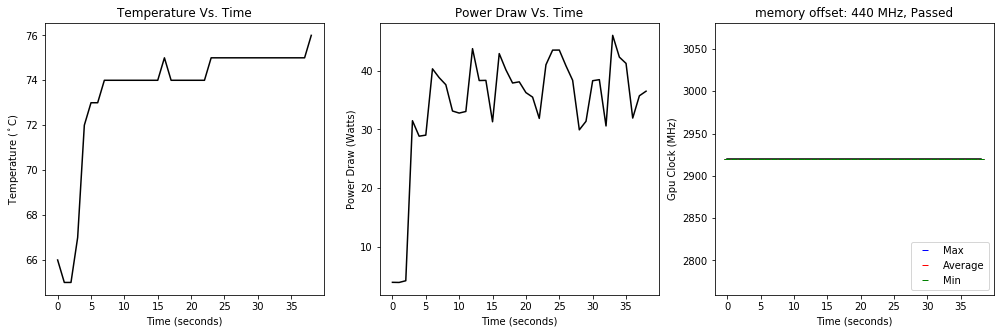

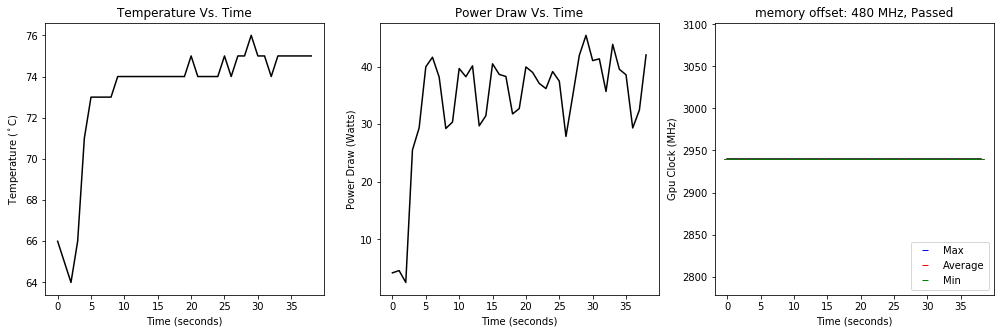

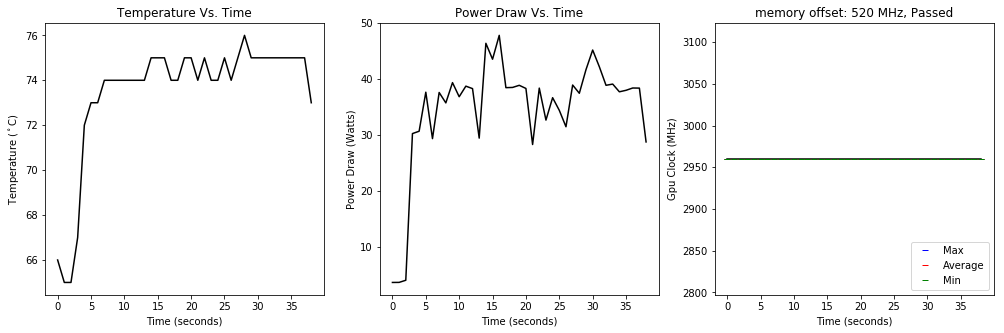

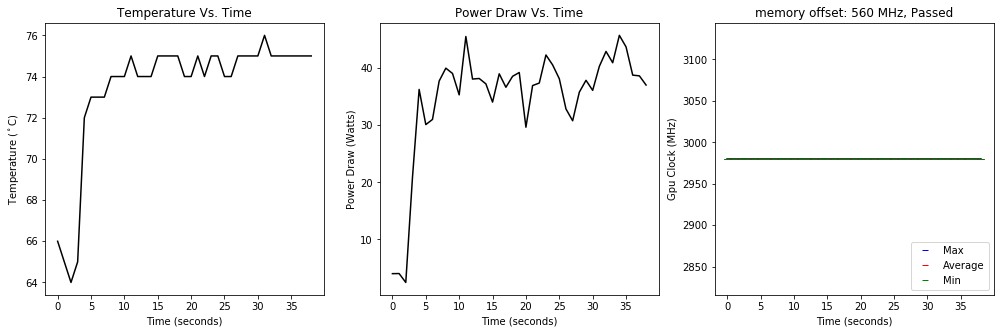

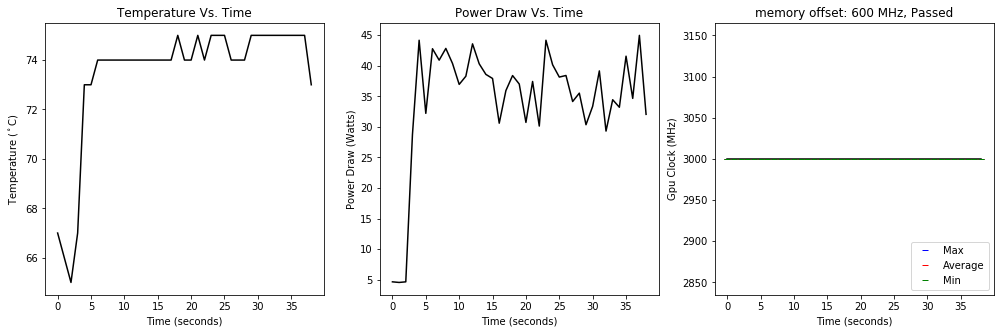

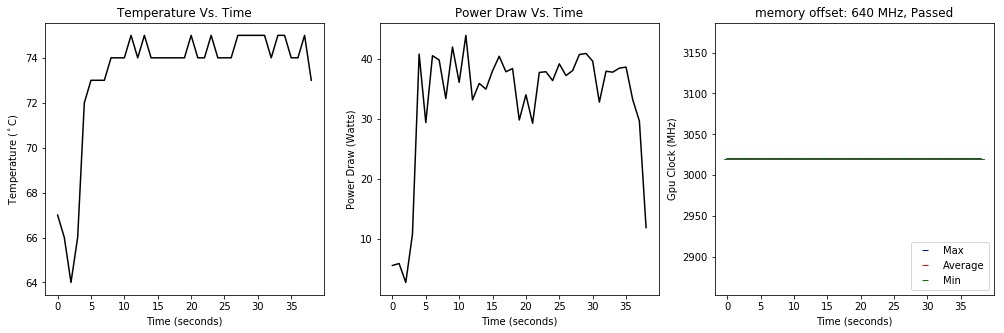

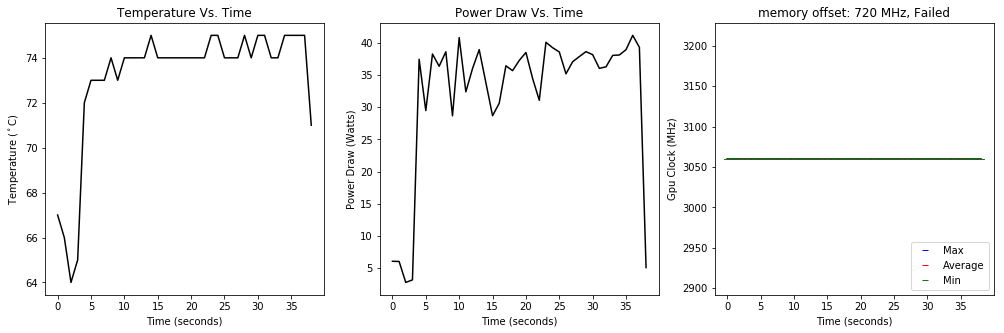

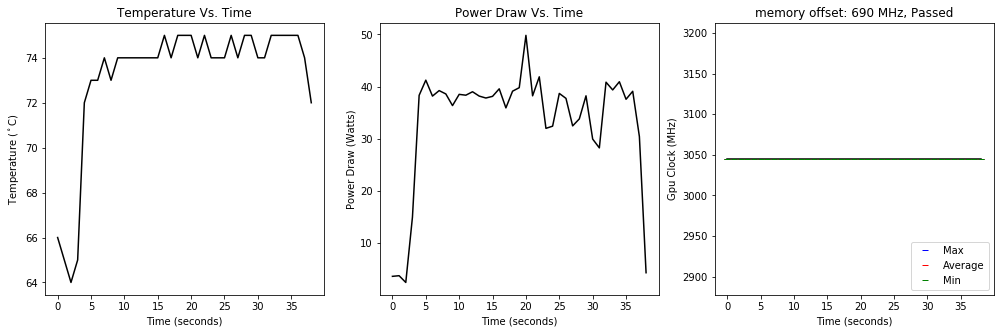

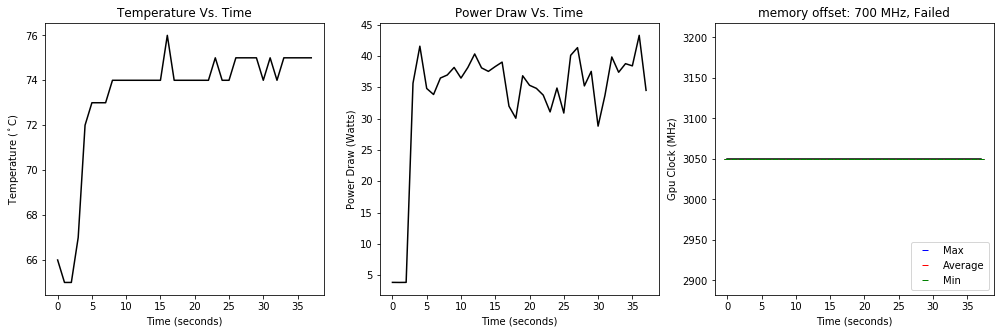

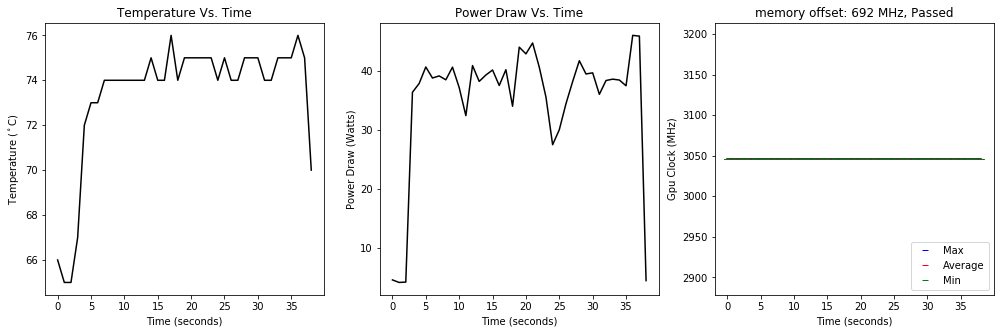

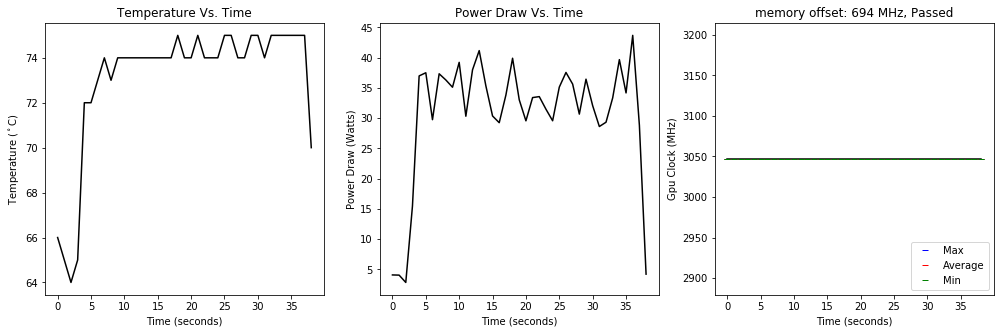

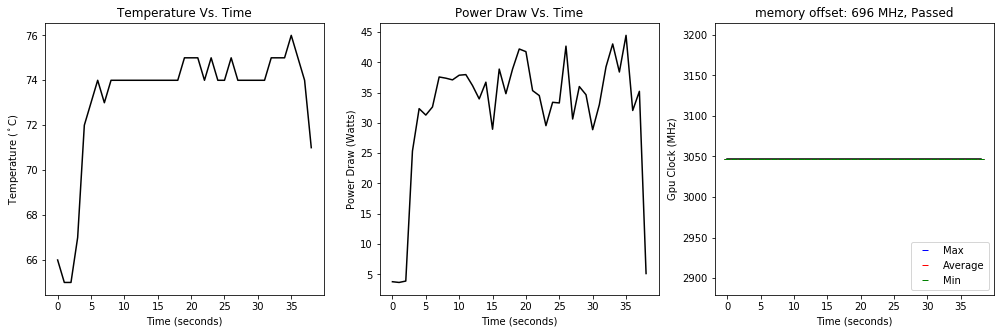

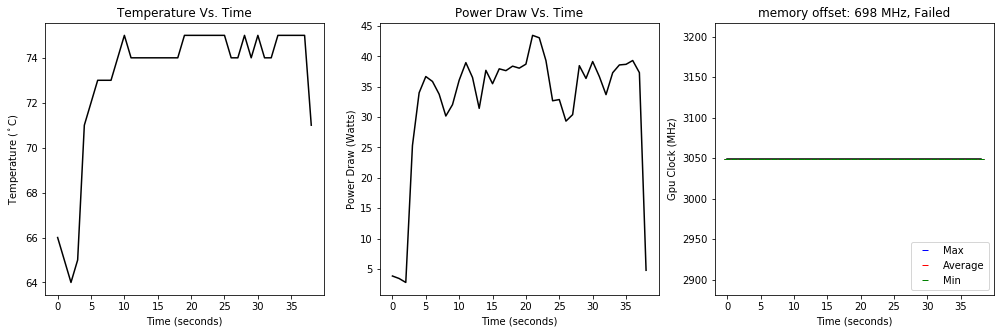

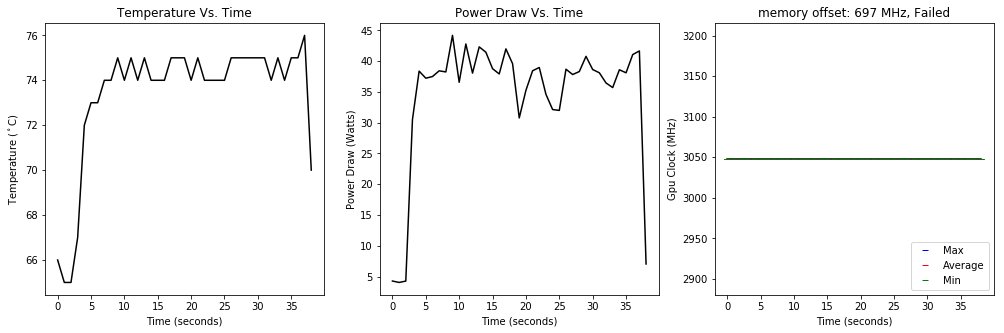

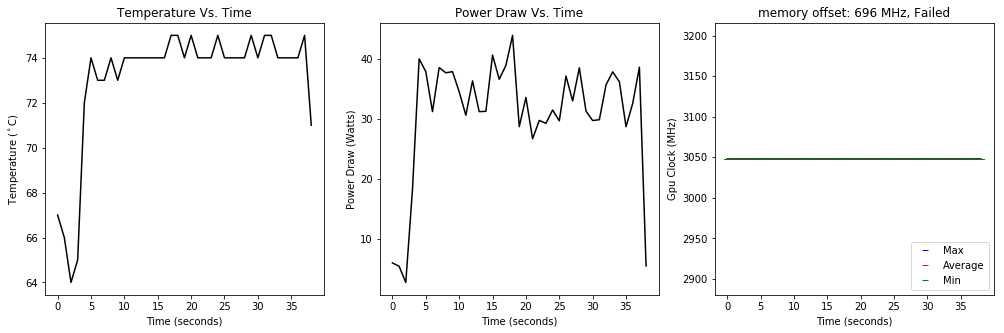

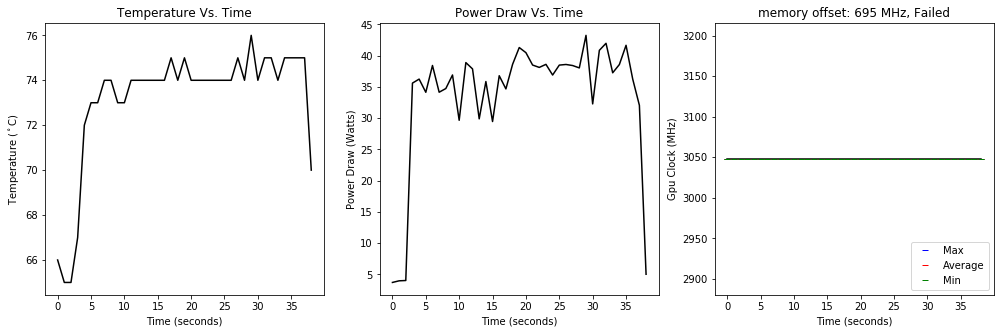

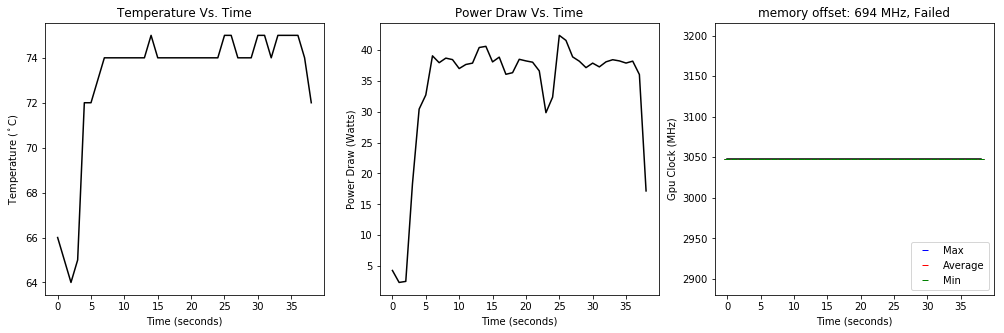

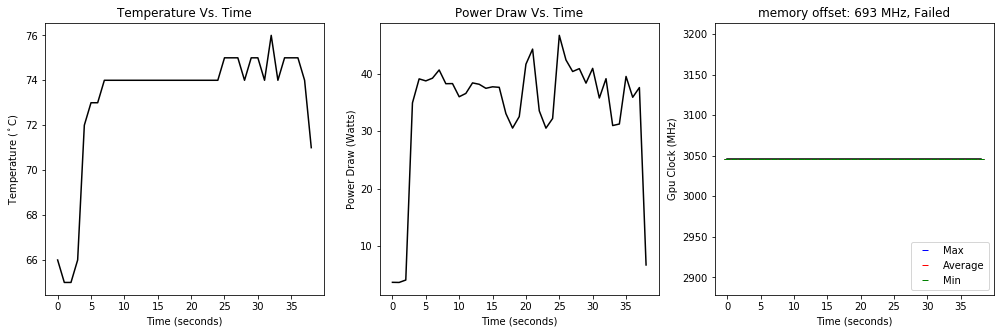

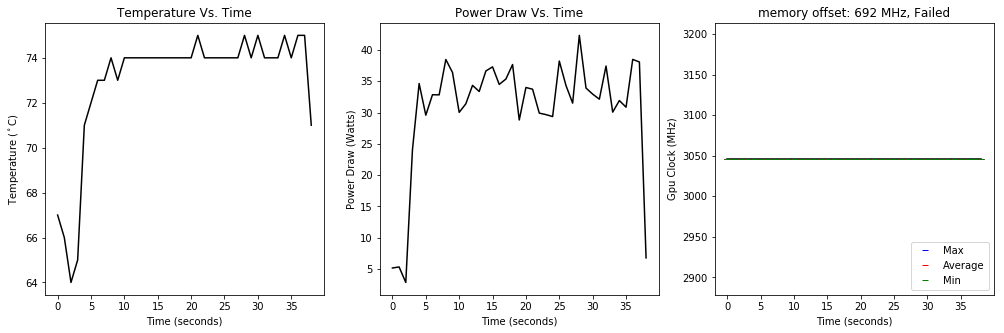

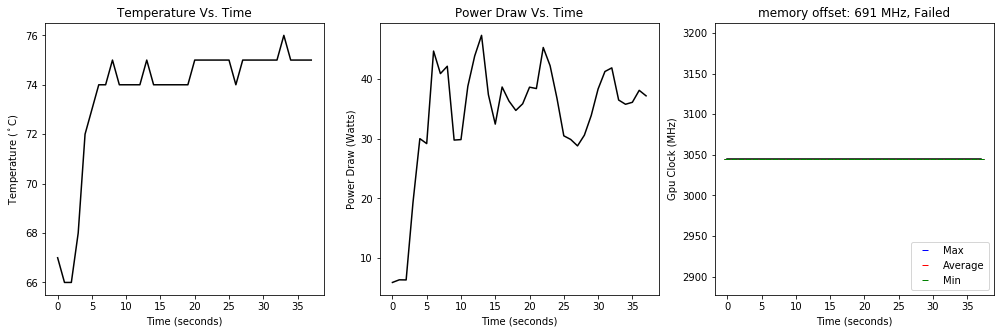

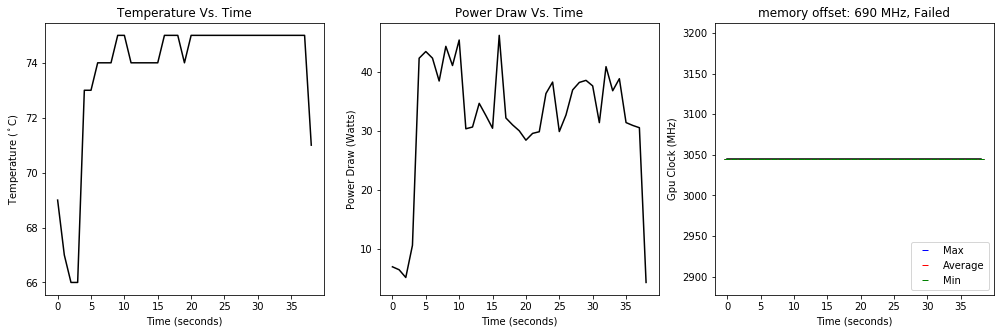

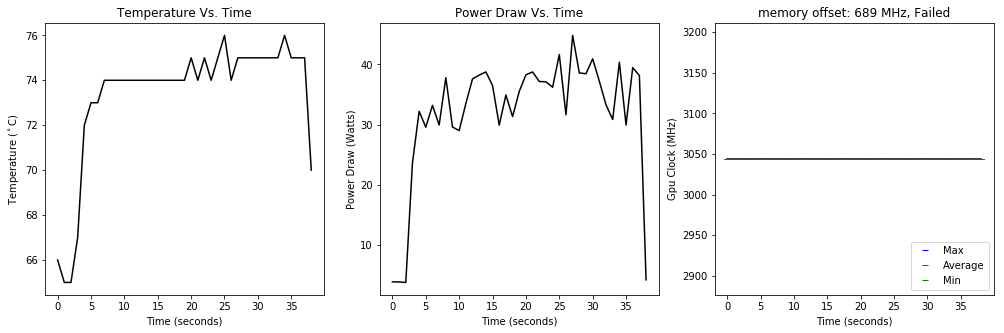

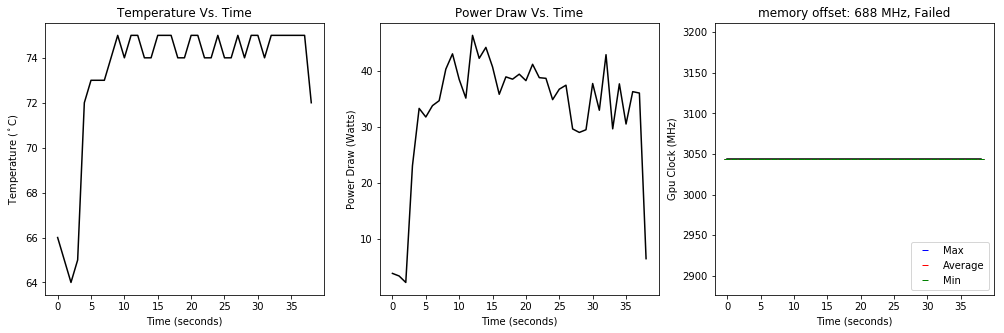

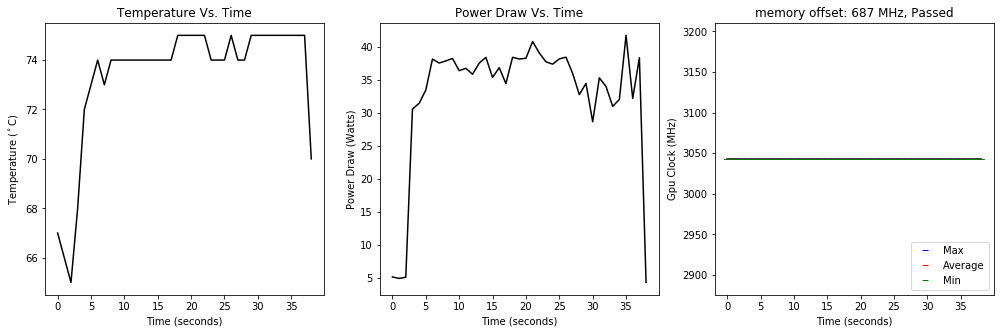

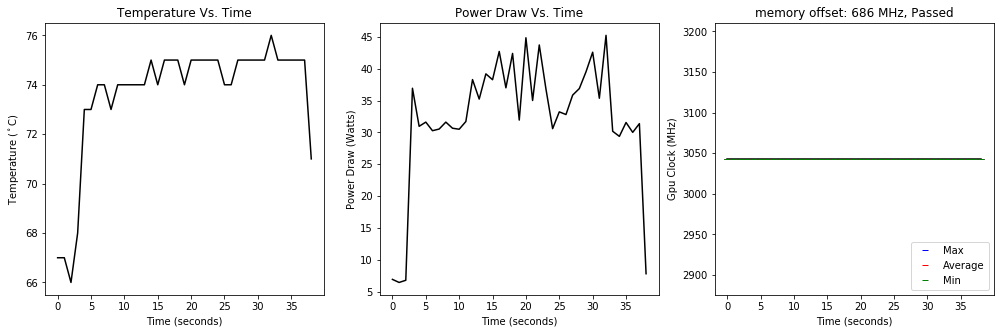

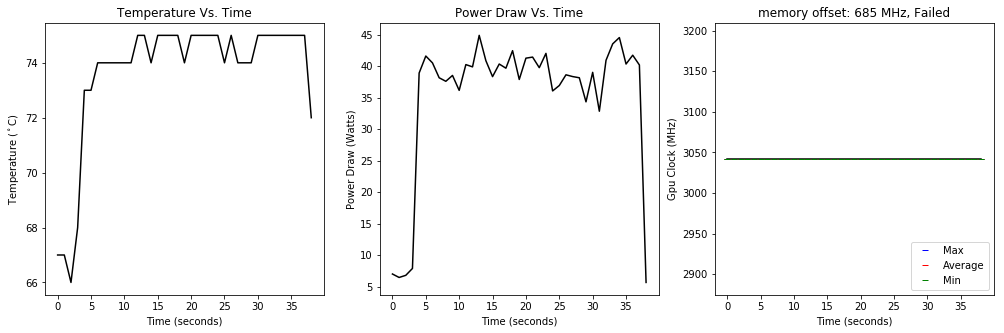

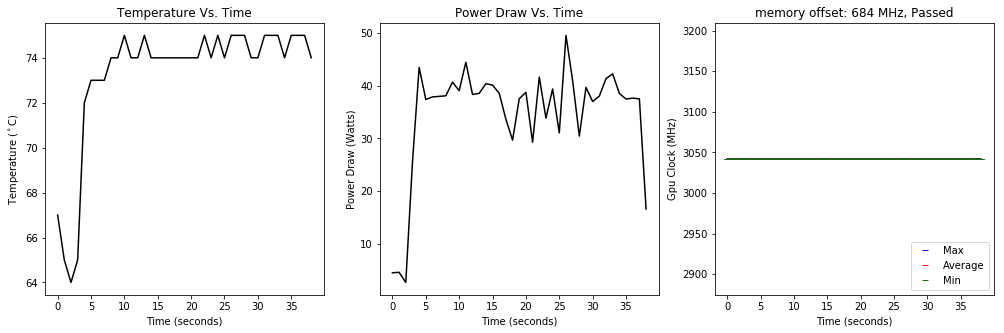

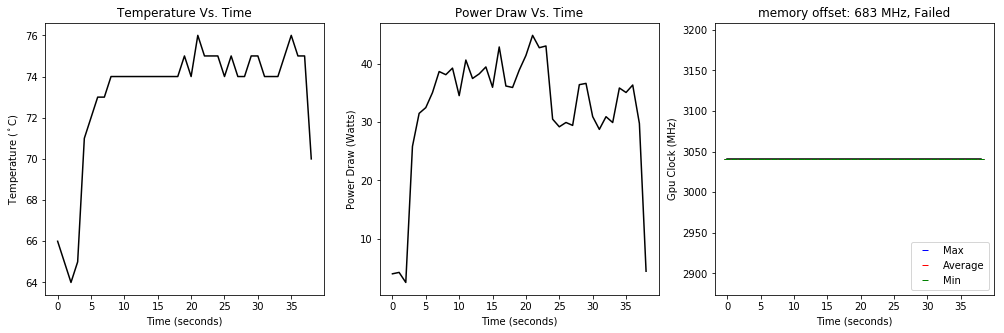

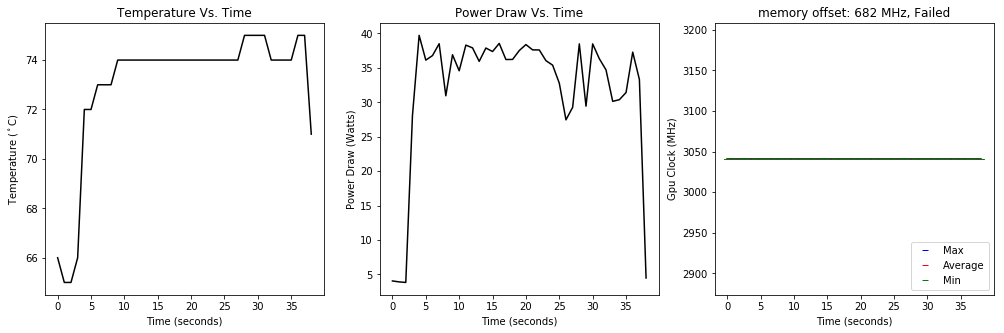

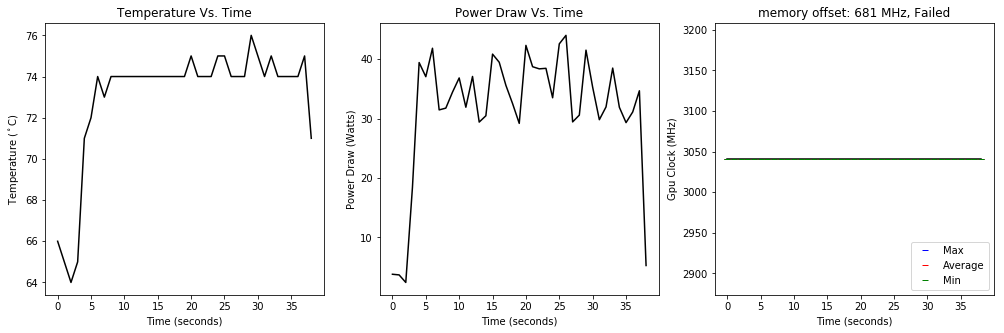

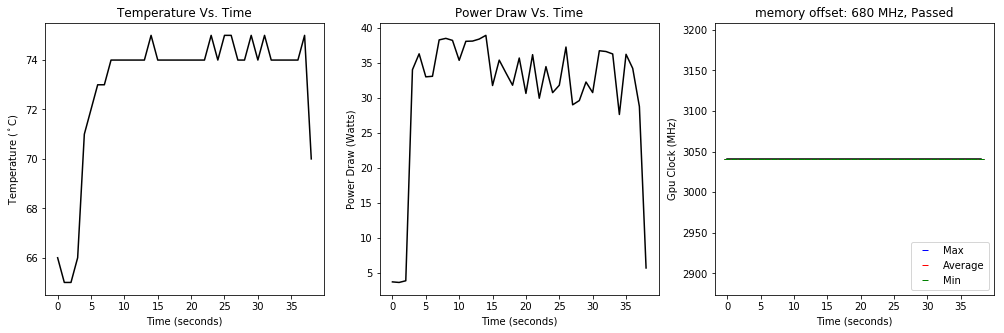

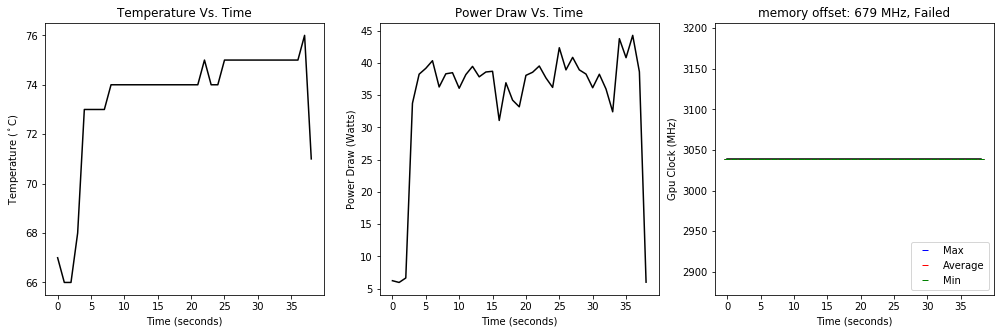

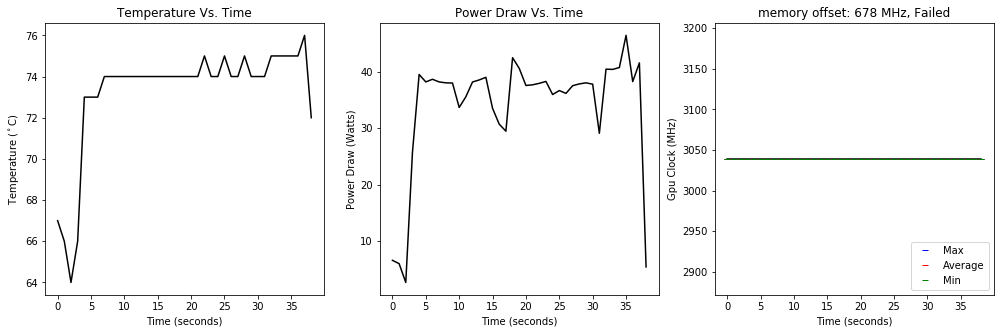

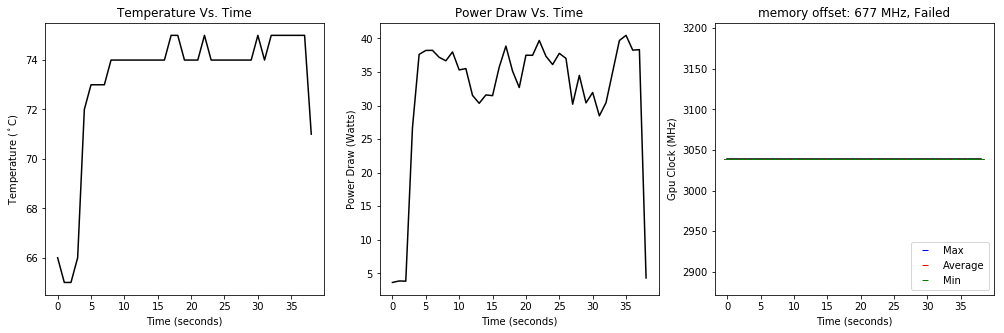

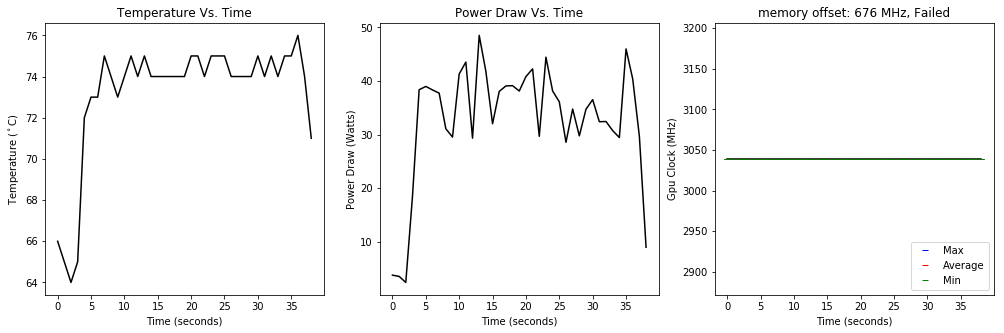

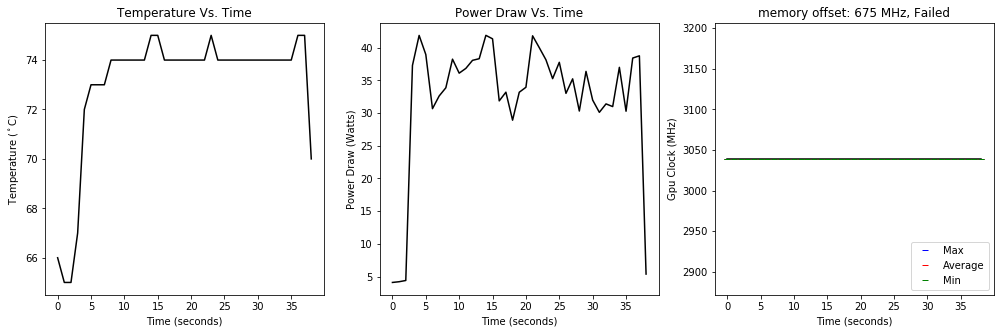

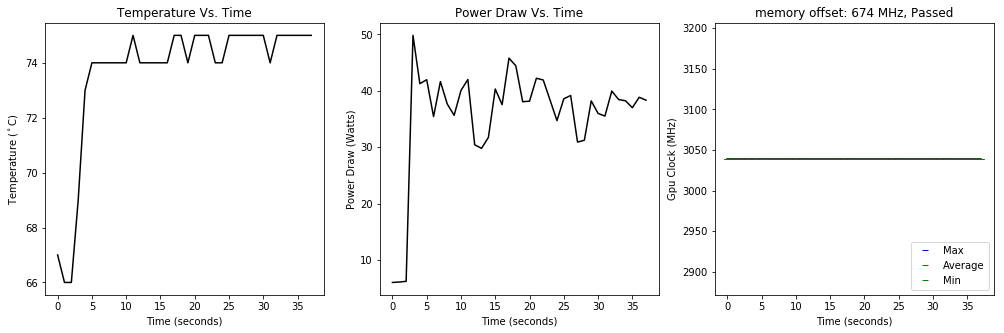

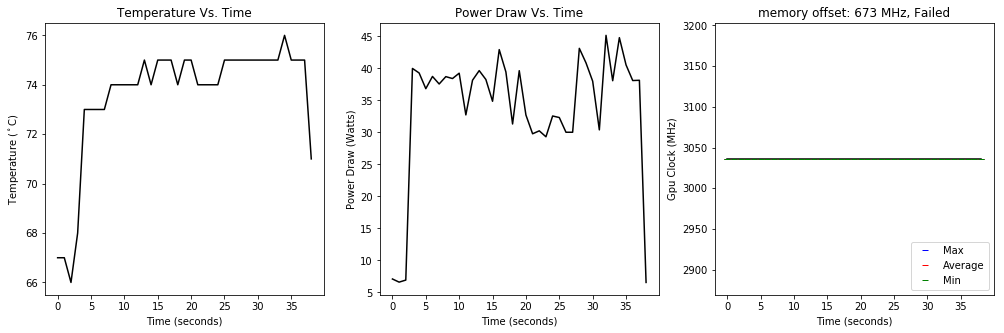

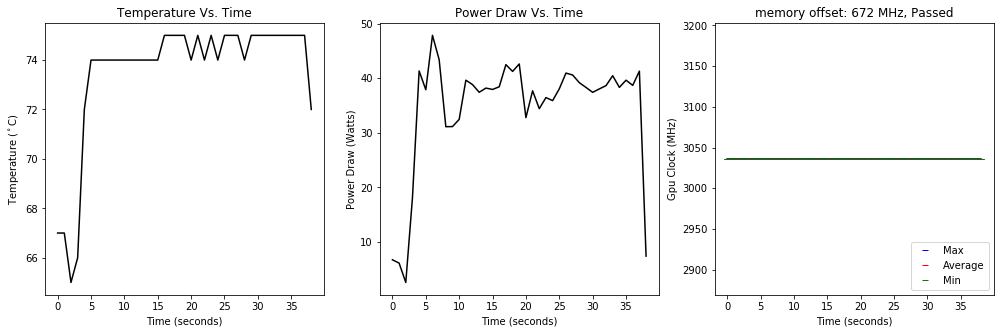

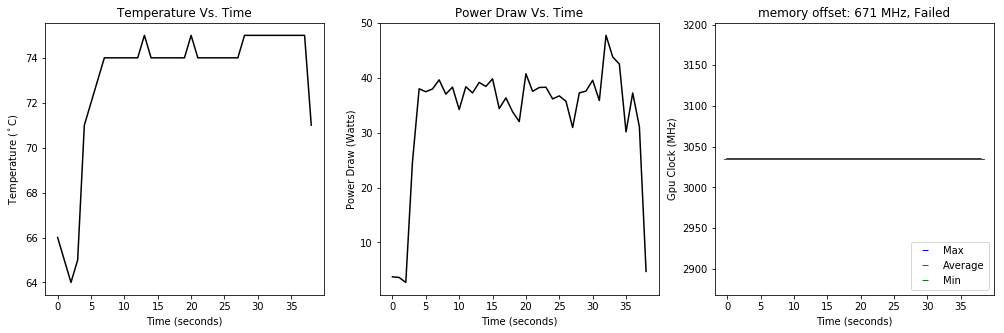

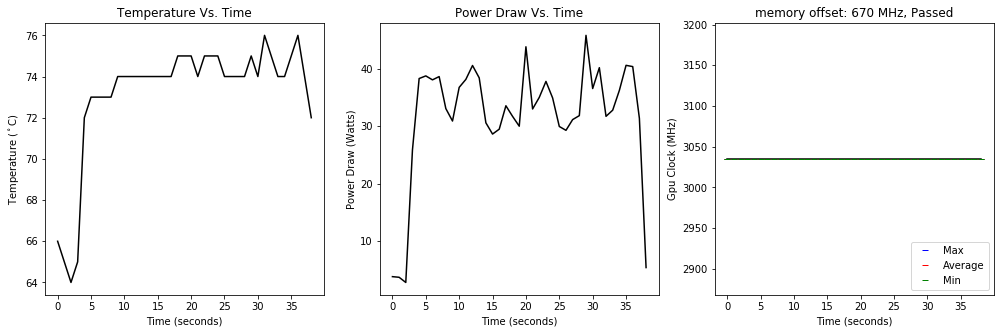

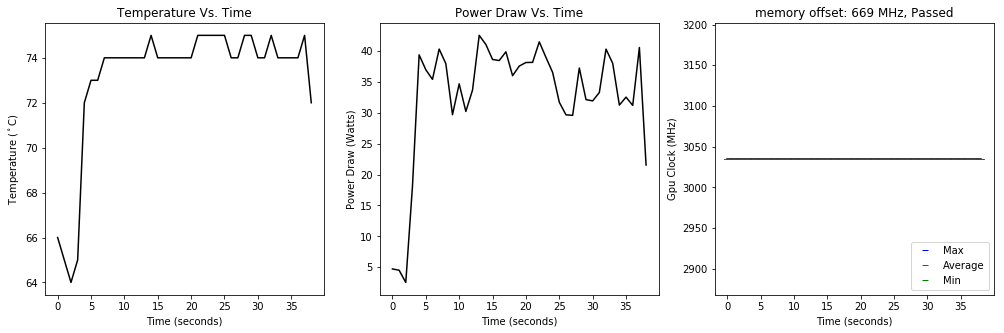

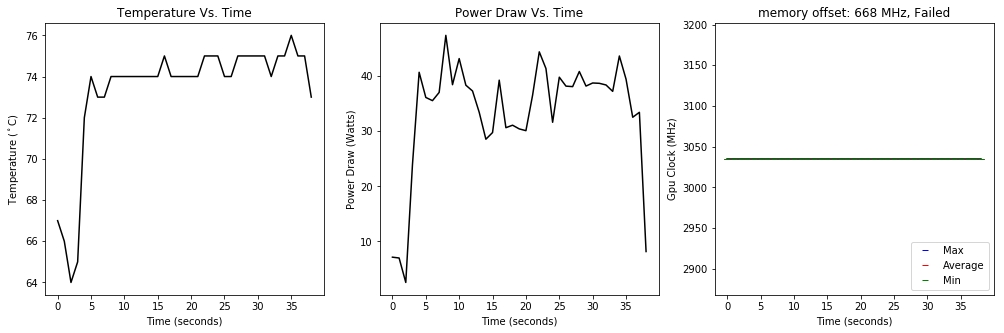

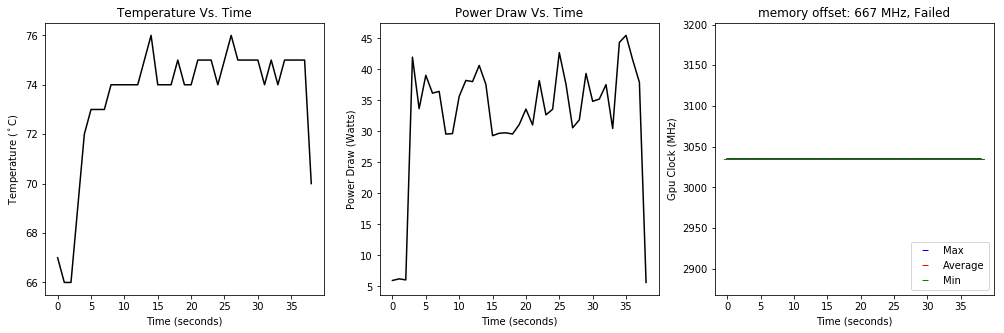

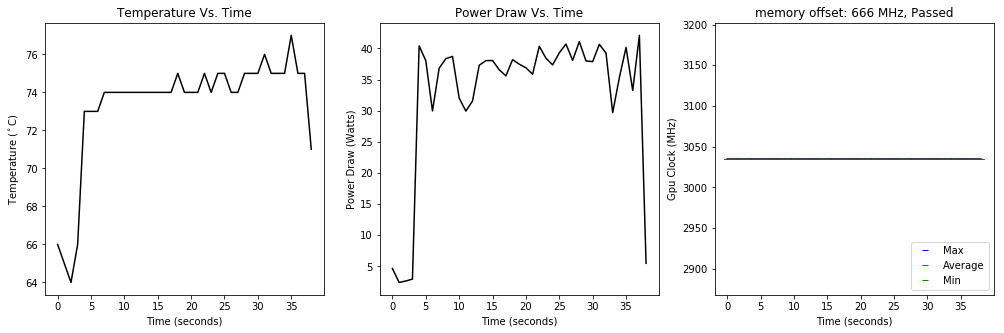

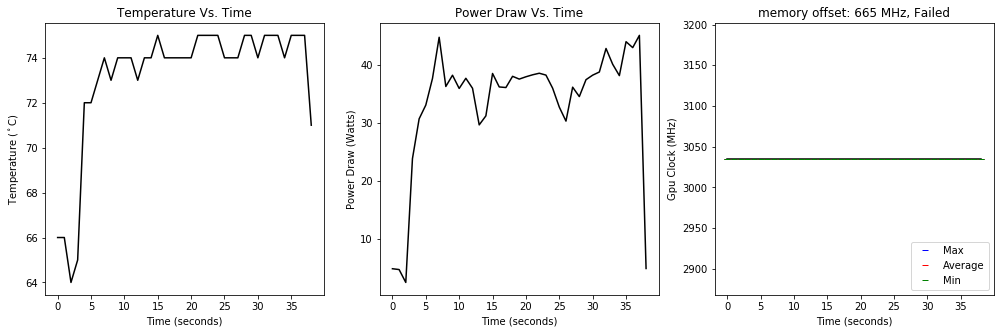

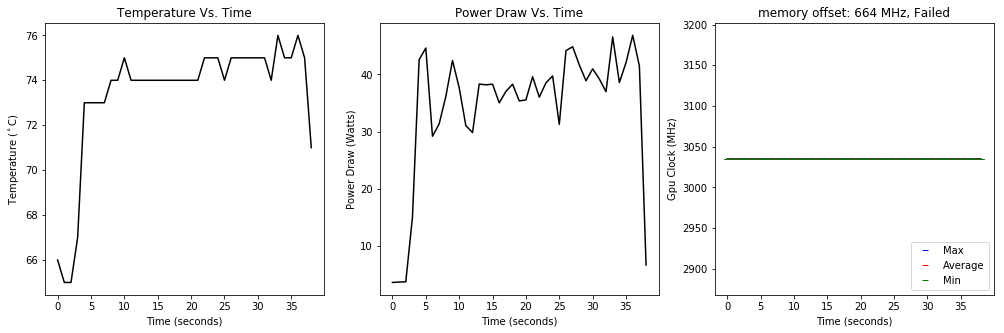

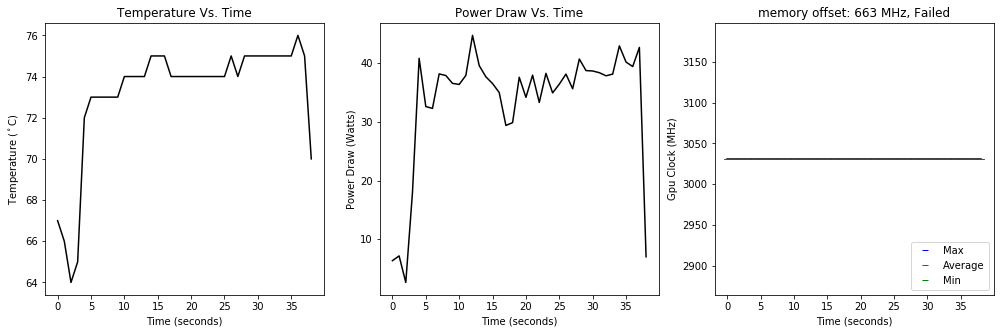

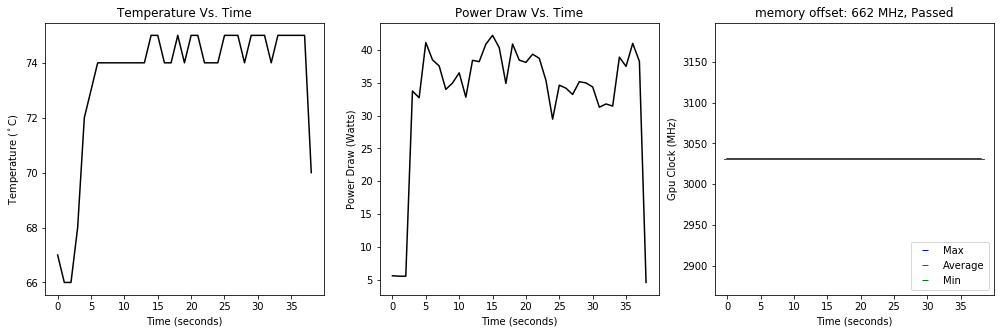

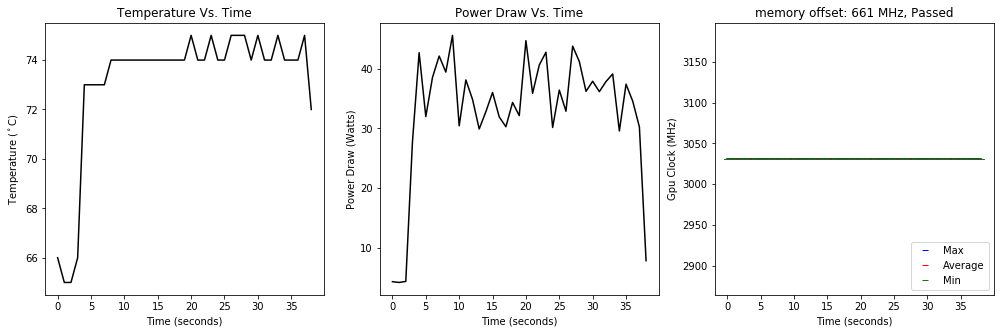

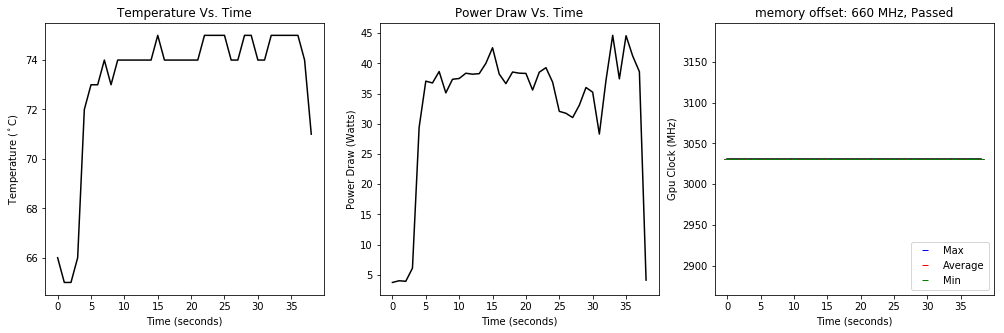

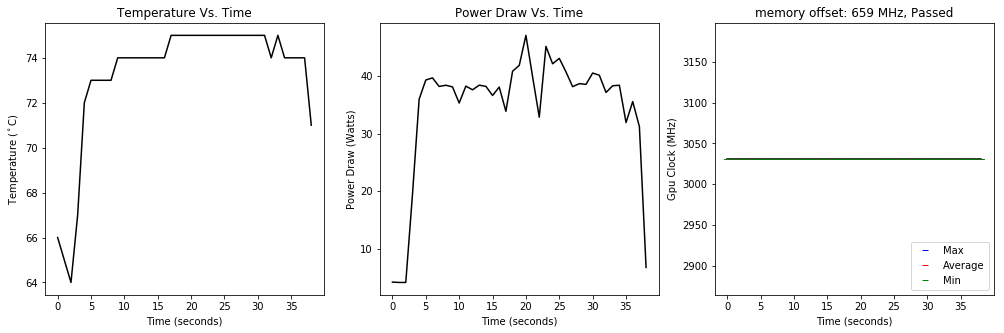

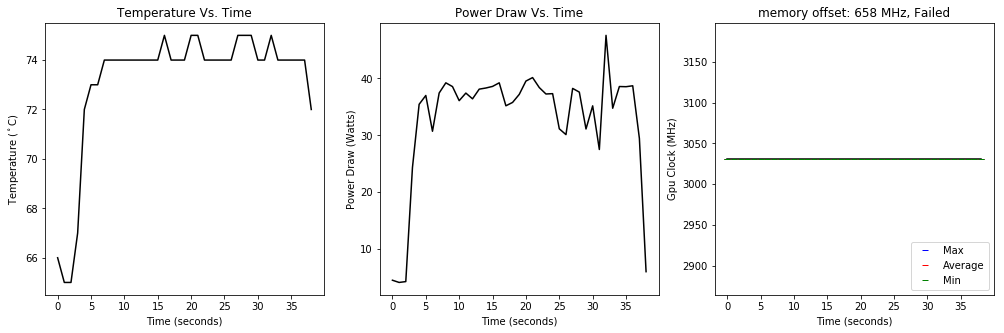

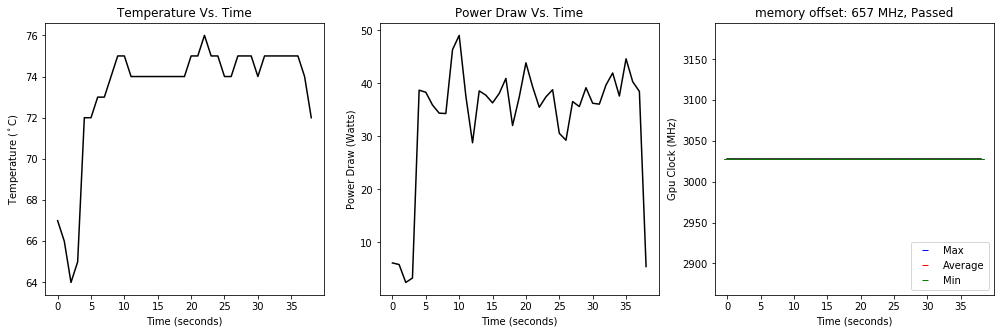

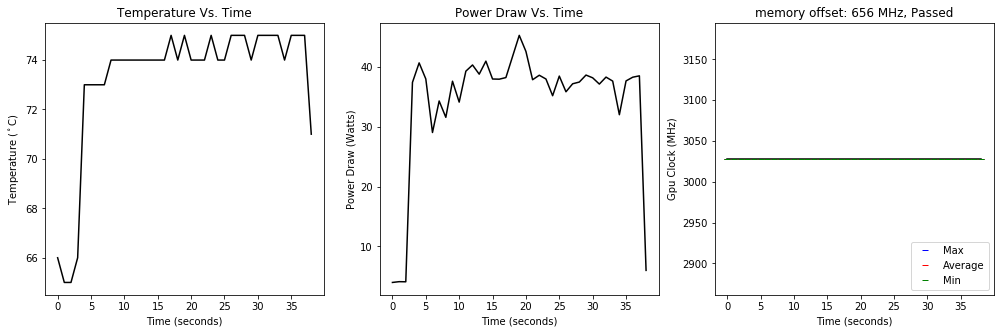

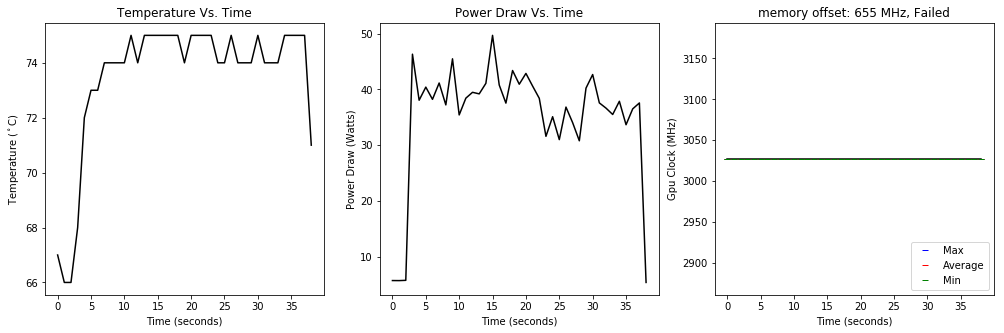

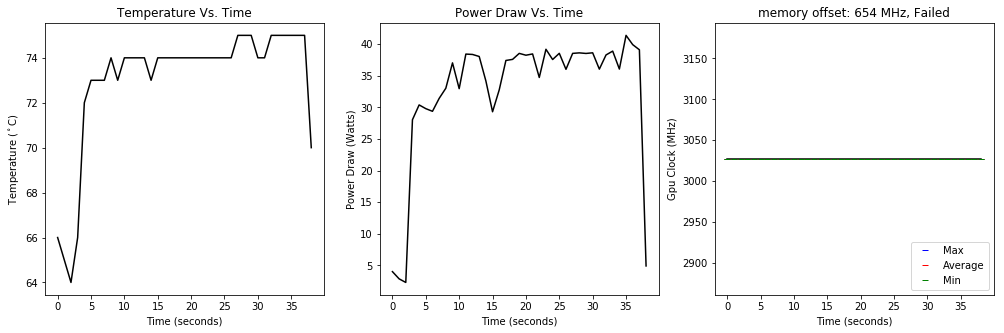

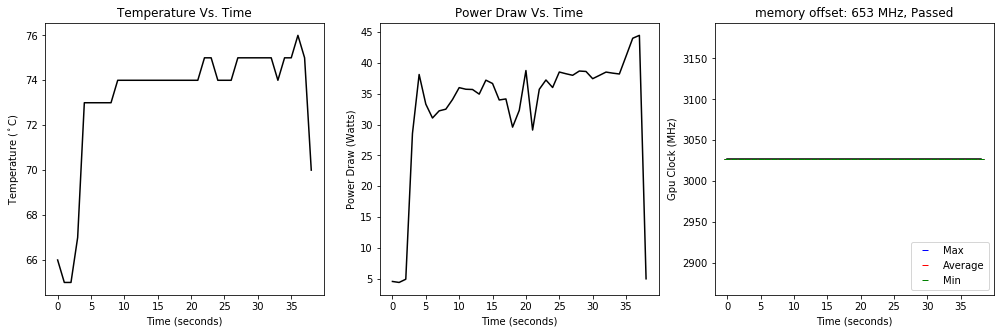

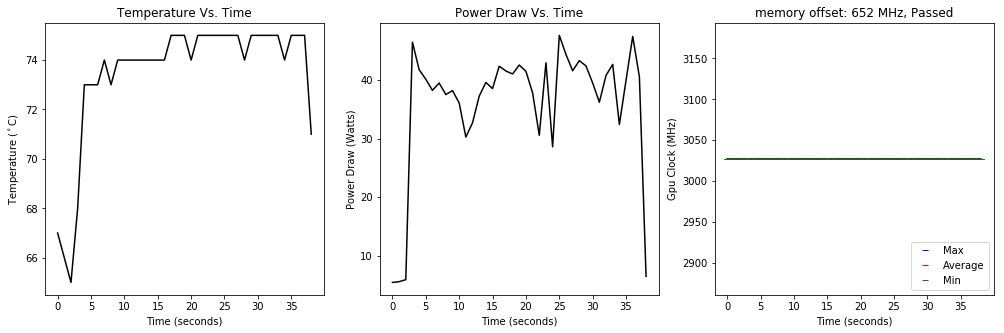

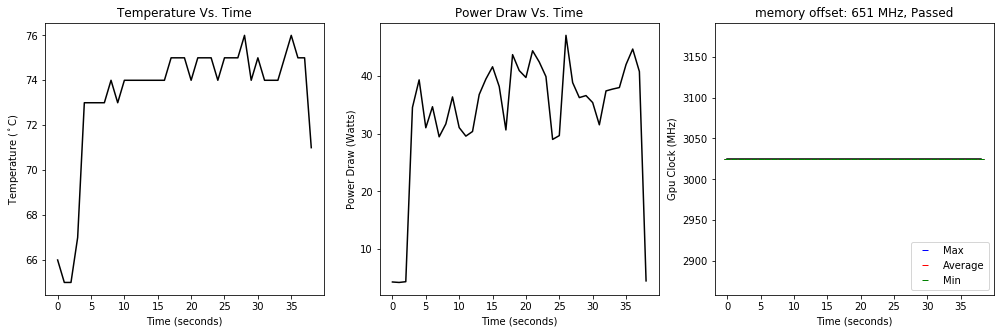

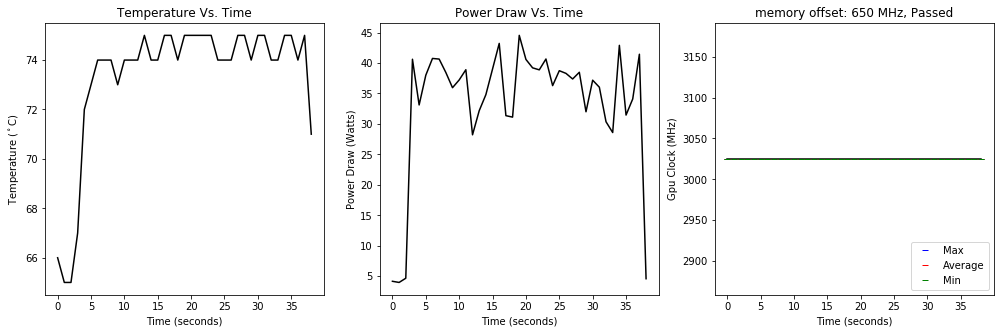

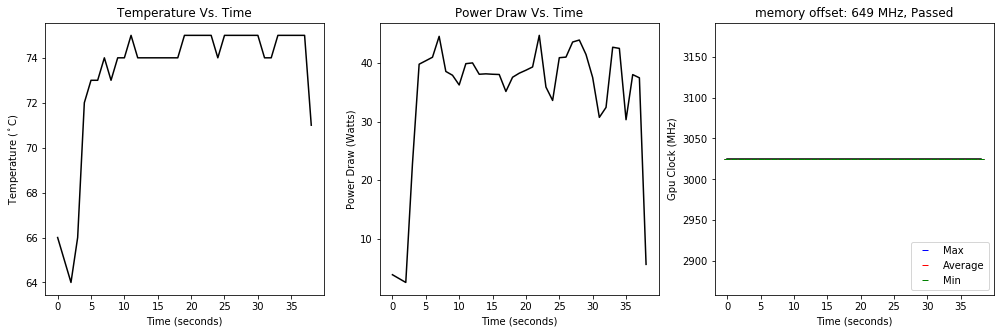

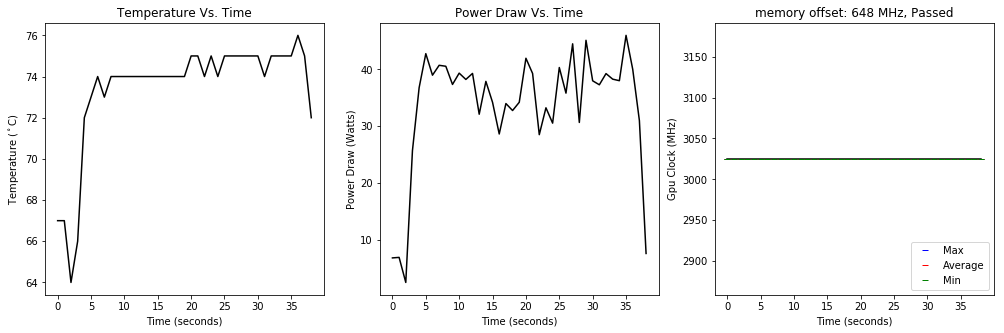

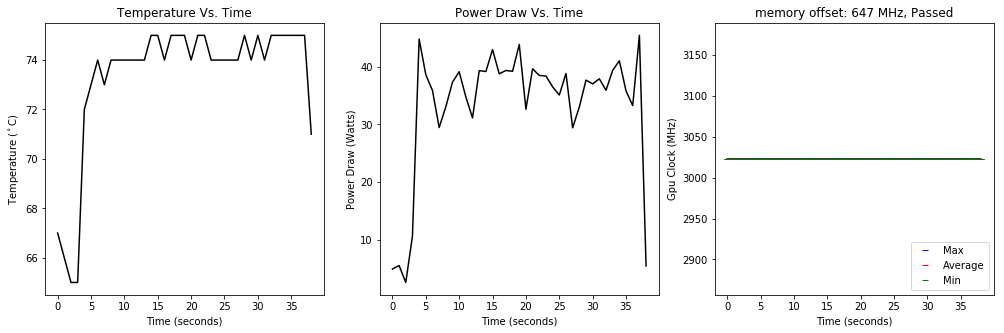

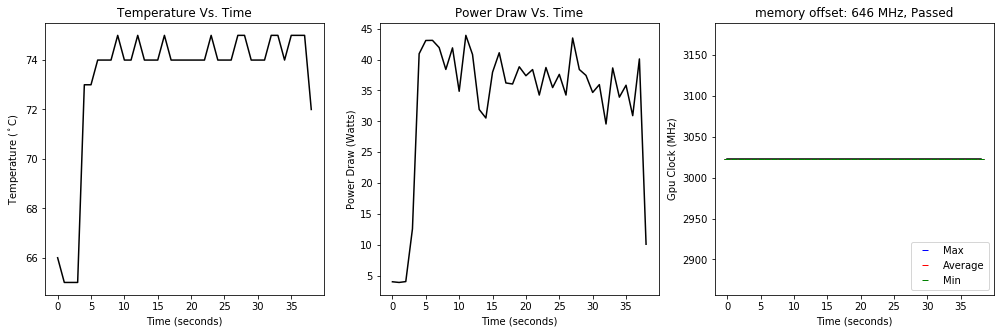

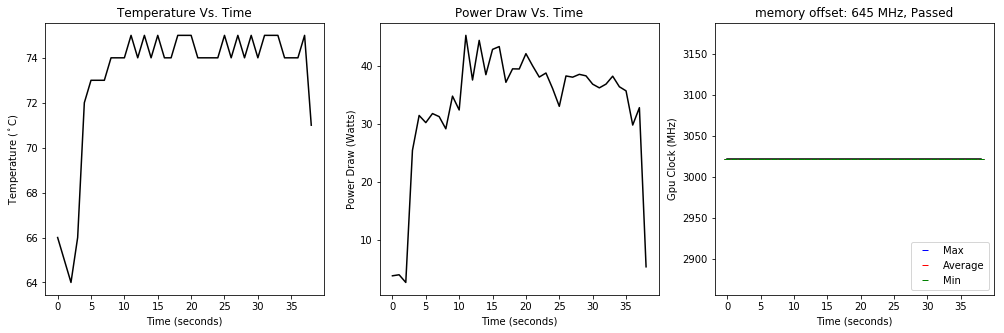

In [7]:
previous_memory_offset = -1
nrows = 1
ncols = 3
sample_rate = 1/1
for i in range(len(profiles)):
    instruction = InstructionDecoder(oc_codes[i])
    if instruction.getMemoryOffset() == 0:
        continue
    
    title_ = ''
    
    # filter failed OC profiles
    if  instruction.getOcStatus()==0 or \
        instruction.getAliveStatus()==0 or \
        instruction.getTemperatureStatus()==0 or \
        instruction.getComputeStatus==0:
        title_ = "memory offset: %s MHz, Failed"%(str(instruction.getMemoryOffset()))
    else:
        title_ = "memory offset: %s MHz, Passed"%(str(instruction.getMemoryOffset()))
        
    if instruction.getMemoryOffset() == previous_memory_offset:
        continue
    else:
        previous_memory_offset = instruction.getMemoryOffset()
    
    temperature = profiles[i][:,0]
    power_draw = profiles[i][:,1]
    gpu_core_clock = profiles[i][:,2]
    sm_clock = profiles[i][:,3]
    memory_clock = profiles[i][:,4]
    time_axis = [sample_rate*i for i in range(len(memory_clock))]
    

    plt.figure(figsize=(17, 5))
    
    plt.subplot(nrows, ncols, 1)
    plt.title("Temperature Vs. Time")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Temperature ($^\circ$C)')
    plt.plot(time_axis, temperature, '-k')
    
    plt.subplot(nrows, ncols, 2)
    plt.title("Power Draw Vs. Time")
    plt.xlabel('Time (seconds)')
    plt.ylabel('Power Draw (Watts)')
    plt.plot(time_axis, power_draw, '-k')
    
    plt.subplot(nrows, ncols, 3)
    plt.title(title_)
    plt.xlabel('Time (seconds)')
    plt.ylabel('Gpu Clock (MHz)')
    plt.plot(time_axis, memory_clock, '-k')
    plt.plot([np.max(memory_clock)]*int(np.ceil(time_axis[-1])+1), '_b', label='Max')
    plt.plot([np.mean(memory_clock[4:])]*int(np.ceil(time_axis[-1])+1), '_r', label='Average')
    plt.plot([np.min(memory_clock)]*int(np.ceil(time_axis[-1])+1), '_g', label='Min')
    plt.legend(loc='lower right')
    
    
    plt.show()